# Colab configuration

In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4400.42
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [ ]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
overlay         116G   46G   71G  40% /
tmpfs            68M     0   68M   0% /dev
shm             6.2G     0  6.2G   0% /dev/shm
/dev/root       2.1G  1.2G  890M  57% /usr/sbin/docker-init
/dev/sda1        75G   49G   27G  65% /kaggle/input
tmpfs           6.9G   41k  6.9G   1% /var/colab
tmpfs           6.9G     0  6.9G   0% /proc/acpi
tmpfs           6.9G     0  6.9G   0% /proc/scsi
tmpfs           6.9G     0  6.9G   0% /sys/firmware


In [ ]:
!free --giga

               total        used        free      shared  buff/cache   available
Mem:              13           0           9           0           3          12
Swap:              0           0           0


# Pre-requisite

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install PySpark (latest version is 3.5.1)

In [2]:
! pip install pyspark==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1a2d5aff2a661b38038f0a2fd2eff627d60b58455d0a3925d40ddaaf180198b4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Check the version of PySpark

In [3]:
! pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.22
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


Initiate a SparkContext

In [4]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [5]:
# import pyspark and initiate a SparkContext
import pyspark
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName('Spark Programming')
sc = SparkContext(conf=conf)

In [6]:
spark = SparkSession.builder.appName("Data Analysis").getOrCreate()

Import the csv dataset file

In [7]:
file_path = "/content/drive/MyDrive/COMP4651 Project/daily_weather_data.csv"

In [8]:
df = spark.read.option("header", True).csv(file_path)

# Part 1: Understand the Dataset

Ask Spark to tell me the data schema

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [ ]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- tavg: string (nullable = true)
 |-- tmin: string (nullable = true)
 |-- tmax: string (nullable = true)
 |-- wdir: string (nullable = true)
 |-- wspd: string (nullable = true)
 |-- pres: string (nullable = true)



In [ ]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType

# Setting an user define function:
# This function converts the string cell into a date:
func = udf(lambda x: datetime.strptime(x, "%d-%m-%Y"), DateType())

# df = df1.withColumn('test', func(col('first')))

df = df.withColumn("date", func(col("date")))

df = df.withColumn("Latitude", df.Latitude.cast('double'))
df = df.withColumn("Longitude", df.Longitude.cast('double'))
df = df.withColumn("tavg", df.tavg.cast('double'))
df = df.withColumn("tmin", df.tmin.cast('double'))
df = df.withColumn("tmax", df.tmax.cast('double'))
df = df.withColumn("wdir", df.wdir.cast('int'))
df = df.withColumn("wspd", df.wspd.cast('double'))
df = df.withColumn("pres", df.pres.cast('double'))

In [ ]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- wdir: integer (nullable = true)
 |-- wspd: double (nullable = true)
 |-- pres: double (nullable = true)



We can see that there are some missing values in the columns:

tavg, tmin, tmax, wdir, wspd, pres

In [ ]:
df.describe().show()

+-------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|       country|     city|          Latitude|         Longitude|              tavg|             tmin|              tmax|              wdir|              wspd|              pres|
+-------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|        277551|   277551|            277551|            277551|            277551|           277551|            277551|            277551|            277551|            277551|
|   mean|          NULL|     NULL|20.756738623539267|12.143805870771454|20.817601089529116|17.22344722231251|24.816747192409238| 164.4588454013857|13.446140348980817|1013.2937553819111|
| stddev|          NULL|     NULL|  25.9935285958216| 72.8212347843046

In [ ]:
df.summary().show()

+-------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|       country|     city|          Latitude|         Longitude|              tavg|             tmin|              tmax|              wdir|              wspd|              pres|
+-------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|        277551|   277551|            277551|            277551|            277551|           277551|            277551|            277551|            277551|            277551|
|   mean|          NULL|     NULL|20.756738623539267|12.143805870771454|20.817601089529116|17.22344722231251|24.816747192409238| 164.4588454013857|13.446140348980817|1013.2937553819111|
| stddev|          NULL|     NULL|  25.9935285958216| 72.8212347843046

Sort date column, country and city columns in ascending order

In [ ]:
from pyspark.sql.functions import desc, asc

df = df.sort(asc("date"), asc("country"), asc("city"))

Show the first 10 rows

In [ ]:
df.show(10)

+----------+--------------------+-------------------+----------+----------+-----+-----+-----+----+----+------+
|      date|             country|               city|  Latitude| Longitude| tavg| tmin| tmax|wdir|wspd|  pres|
+----------+--------------------+-------------------+----------+----------+-----+-----+-----+----+----+------+
|2018-01-01|       Aland Islands|          Mariehamn|      60.1| 19.933333|  2.8|  1.1|  4.1| 137|12.8| 990.1|
|2018-01-01|             Albania|             Tirana| 41.327546| 19.818698|  6.7| -1.3| 11.7| 168| 6.2|1018.0|
|2018-01-01|             Algeria|            Algiers| 36.752887|  3.042048| 16.2|  9.7| 16.9| 235|15.6|1030.4|
|2018-01-01|             Austria|             Vienna| 48.208174| 16.373819|  5.9|  3.1| 10.0| 181|11.6|1009.2|
|2018-01-01|             Belgium|           Brussels|  50.85034|   4.35171|  6.1|  4.9|  8.5| 218|23.0|1000.3|
|2018-01-01|              Brunei|Bandar Seri Begawan|  4.903052|114.939821| 27.8| 21.1| 30.7|  47|10.2|1007.7|
|

Show the number of rows

In [ ]:
print("Number of rows in total: ", df.count())

Number of rows in total:  277551


Define functions to count unique items

In [ ]:
from pyspark.sql.functions import countDistinct

def count_distinct_items(col_name):
    df.agg(countDistinct(col_name)).show(truncate = False)

Show the number of unique dates

In [ ]:
print("Number of distinct dates:")
count_distinct_items("date")

Number of distinct dates:
+--------------------+
|count(DISTINCT date)|
+--------------------+
|1745                |
+--------------------+



Show the number of unique countries

In [ ]:
print("Number of distinct countries:")
count_distinct_items("country")

Number of distinct countries:
+-----------------------+
|count(DISTINCT country)|
+-----------------------+
|193                    |
+-----------------------+



Show the number of unique cities

In [ ]:
print("Number of distinct cities:")
count_distinct_items("city")

Number of distinct cities:
+--------------------+
|count(DISTINCT city)|
+--------------------+
|191                 |
+--------------------+



Define function to show number of items under each unique group

In [ ]:
import sys
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc, asc

def count_in_each_unique_group(col_name):
    df.groupBy(col_name).count().sort(asc(col_name)).show(n = 2000, truncate = False)

    # data = df.groupBy(col_name).count().toPandas()

    # plt.barh(data["date"], data["count"])
    # plt.show()

In [ ]:
count_in_each_unique_group("date")

+----------+-----+
|date      |count|
+----------+-----+
|2018-01-01|59   |
|2018-01-02|61   |
|2018-01-03|50   |
|2018-01-04|58   |
|2018-01-05|56   |
|2018-01-06|63   |
|2018-01-07|63   |
|2018-01-08|54   |
|2018-01-09|59   |
|2018-01-10|56   |
|2018-01-11|58   |
|2018-01-12|62   |
|2018-01-13|66   |
|2018-01-14|59   |
|2018-01-15|62   |
|2018-01-16|57   |
|2018-01-17|62   |
|2018-01-18|56   |
|2018-01-19|57   |
|2018-01-20|54   |
|2018-01-21|62   |
|2018-01-22|51   |
|2018-01-23|56   |
|2018-01-24|53   |
|2018-01-25|55   |
|2018-01-26|60   |
|2018-01-27|60   |
|2018-01-28|56   |
|2018-01-29|63   |
|2018-01-30|61   |
|2018-01-31|32   |
|2018-02-01|64   |
|2018-02-02|71   |
|2018-02-03|68   |
|2018-02-04|66   |
|2018-02-05|62   |
|2018-02-06|60   |
|2018-02-07|67   |
|2018-02-08|63   |
|2018-02-09|58   |
|2018-02-10|60   |
|2018-02-11|70   |
|2018-02-12|69   |
|2018-02-13|76   |
|2018-02-14|62   |
|2018-02-15|67   |
|2018-02-16|55   |
|2018-02-17|65   |
|2018-02-18|68   |
|2018-02-19|

In [ ]:
count_in_each_unique_group("country")

+--------------------------------------------+-----+
|country                                     |count|
+--------------------------------------------+-----+
|Abkhazia                                    |1532 |
|Aland Islands                               |1738 |
|Albania                                     |1724 |
|Algeria                                     |1578 |
|American Samoa                              |1589 |
|Angola                                      |1543 |
|Anguilla                                    |1638 |
|Antigua and Barbuda                         |1544 |
|Argentina                                   |1619 |
|Aruba                                       |1552 |
|Austria                                     |1715 |
|Azerbaijan                                  |1601 |
|Bahamas                                     |1434 |
|Bahrain                                     |1593 |
|Bangladesh                                  |1223 |
|Barbados                                    |

In [ ]:
count_in_each_unique_group("city")

+---------------------------+-----+
|city                       |count|
+---------------------------+-----+
|Abu Dhabi                  |1625 |
|Accra                      |1599 |
|Adamstown                  |1392 |
|Algiers                    |1578 |
|Alofi                      |648  |
|Amsterdam                  |1740 |
|Apia                       |653  |
|Ashgabat                   |1544 |
|Astana                     |1464 |
|Asuncion                   |1505 |
|Athens                     |1536 |
|Avarua                     |1601 |
|Baghdad                    |1542 |
|Baku                       |1601 |
|Bamako                     |1642 |
|Bandar Seri Begawan        |1662 |
|Bangkok                    |1604 |
|Bangui                     |1301 |
|Banjul                     |1533 |
|Basse-Terre                |1595 |
|Basseterre                 |1574 |
|Beijing                    |1559 |
|Beirut                     |1575 |
|Belgrade                   |1720 |
|Berlin                     

In [ ]:
from pyspark.sql.functions import max, min, mean, median, mode

def show_stat(group_col, stat_col):
    df.groupBy(group_col).agg(min(stat_col)).sort(asc(group_col)).show(n = 2000, truncate = False)
    df.groupBy(group_col).agg(max(stat_col)).sort(asc(group_col)).show(n = 2000, truncate = False)
    df.groupBy(group_col).agg(mean(stat_col)).sort(asc(group_col)).show(n = 2000, truncate = False)
    df.groupBy(group_col).agg(median(stat_col)).sort(asc(group_col)).show(n = 2000, truncate = False)
    df.groupBy(group_col).agg(mode(stat_col)).sort(asc(group_col)).show(n = 2000, truncate = False)

In [ ]:
show_stat("country", "tavg")

+--------------------------------------------+---------+
|country                                     |min(tavg)|
+--------------------------------------------+---------+
|Abkhazia                                    |-1.4     |
|Aland Islands                               |-15.2    |
|Albania                                     |-1.5     |
|Algeria                                     |8.6      |
|American Samoa                              |23.1     |
|Angola                                      |19.7     |
|Anguilla                                    |23.8     |
|Antigua and Barbuda                         |23.1     |
|Argentina                                   |5.5      |
|Aruba                                       |25.1     |
|Austria                                     |-8.8     |
|Azerbaijan                                  |-4.2     |
|Bahamas                                     |16.3     |
|Bahrain                                     |11.9     |
|Bangladesh                    

In [ ]:
show_stat("country", "tmin")

+--------------------------------------------+---------+
|country                                     |min(tmin)|
+--------------------------------------------+---------+
|Abkhazia                                    |-4.1     |
|Aland Islands                               |-22.3    |
|Albania                                     |-9.4     |
|Algeria                                     |-0.3     |
|American Samoa                              |18.8     |
|Angola                                      |15.0     |
|Anguilla                                    |19.6     |
|Antigua and Barbuda                         |20.0     |
|Argentina                                   |1.9      |
|Aruba                                       |15.7     |
|Austria                                     |-11.6    |
|Azerbaijan                                  |-5.4     |
|Bahamas                                     |9.6      |
|Bahrain                                     |9.6      |
|Bangladesh                    

In [ ]:
show_stat("country", "tmax")

+--------------------------------------------+---------+
|country                                     |min(tmax)|
+--------------------------------------------+---------+
|Abkhazia                                    |0.0      |
|Aland Islands                               |-12.2    |
|Albania                                     |2.1      |
|Algeria                                     |9.2      |
|American Samoa                              |25.3     |
|Angola                                      |22.5     |
|Anguilla                                    |25.6     |
|Antigua and Barbuda                         |24.4     |
|Argentina                                   |7.7      |
|Aruba                                       |26.7     |
|Austria                                     |-7.2     |
|Azerbaijan                                  |-2.5     |
|Bahamas                                     |19.0     |
|Bahrain                                     |13.6     |
|Bangladesh                    

In [ ]:
show_stat("country", "wdir")

+--------------------------------------------+---------+
|country                                     |min(wdir)|
+--------------------------------------------+---------+
|Abkhazia                                    |0        |
|Aland Islands                               |0        |
|Albania                                     |0        |
|Algeria                                     |0        |
|American Samoa                              |0        |
|Angola                                      |4        |
|Anguilla                                    |0        |
|Antigua and Barbuda                         |1        |
|Argentina                                   |0        |
|Aruba                                       |19       |
|Austria                                     |0        |
|Azerbaijan                                  |0        |
|Bahamas                                     |1        |
|Bahrain                                     |0        |
|Bangladesh                    

In [ ]:
show_stat("country", "wspd")

+--------------------------------------------+---------+
|country                                     |min(wspd)|
+--------------------------------------------+---------+
|Abkhazia                                    |4.4      |
|Aland Islands                               |1.3      |
|Albania                                     |1.9      |
|Algeria                                     |1.9      |
|American Samoa                              |3.6      |
|Angola                                      |5.3      |
|Anguilla                                    |1.3      |
|Antigua and Barbuda                         |3.6      |
|Argentina                                   |3.0      |
|Aruba                                       |6.3      |
|Austria                                     |4.2      |
|Azerbaijan                                  |4.4      |
|Bahamas                                     |3.5      |
|Bahrain                                     |4.9      |
|Bangladesh                    

In [ ]:
show_stat("country", "pres")

+--------------------------------------------+---------+
|country                                     |min(pres)|
+--------------------------------------------+---------+
|Abkhazia                                    |998.2    |
|Aland Islands                               |962.6    |
|Albania                                     |981.2    |
|Algeria                                     |999.9    |
|American Samoa                              |994.9    |
|Angola                                      |1006.4   |
|Anguilla                                    |977.0    |
|Antigua and Barbuda                         |1009.0   |
|Argentina                                   |996.9    |
|Aruba                                       |1007.7   |
|Austria                                     |989.9    |
|Azerbaijan                                  |995.2    |
|Bahamas                                     |1007.0   |
|Bahrain                                     |992.3    |
|Bangladesh                    

# Part 2: Data Preprocessing/Cleaning & Basic Data Visualization

Drop the rows with NULL or NA in any columns

In [ ]:
df = df.na.drop(how = "any").cache()

In [ ]:
df.show()

+----------+--------------------+-------------------+----------+----------+-----+-----+-----+----+----+------+
|      date|             country|               city|  Latitude| Longitude| tavg| tmin| tmax|wdir|wspd|  pres|
+----------+--------------------+-------------------+----------+----------+-----+-----+-----+----+----+------+
|2018-01-01|       Aland Islands|          Mariehamn|      60.1| 19.933333|  2.8|  1.1|  4.1| 137|12.8| 990.1|
|2018-01-01|             Albania|             Tirana| 41.327546| 19.818698|  6.7| -1.3| 11.7| 168| 6.2|1018.0|
|2018-01-01|             Algeria|            Algiers| 36.752887|  3.042048| 16.2|  9.7| 16.9| 235|15.6|1030.4|
|2018-01-01|             Austria|             Vienna| 48.208174| 16.373819|  5.9|  3.1| 10.0| 181|11.6|1009.2|
|2018-01-01|             Belgium|           Brussels|  50.85034|   4.35171|  6.1|  4.9|  8.5| 218|23.0|1000.3|
|2018-01-01|              Brunei|Bandar Seri Begawan|  4.903052|114.939821| 27.8| 21.1| 30.7|  47|10.2|1007.7|
|

After data cleaning, we have 277551 number of data left

In [ ]:
df.describe().show()

+-------+--------------+---------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|       country|     city|          Latitude|         Longitude|              tavg|             tmin|             tmax|              wdir|              wspd|              pres|
+-------+--------------+---------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|  count|        277551|   277551|            277551|            277551|            277551|           277551|           277551|            277551|            277551|            277551|
|   mean|          NULL|     NULL|20.756738623535117|12.143805870770407|20.817601089529486|17.22344722231229|24.81674719240784| 164.4588454013857|13.446140348980913|1013.2937553818939|
| stddev|          NULL|     NULL| 25.99352859582159| 72.82123478430485|  9

In [ ]:
df.summary().show()

+-------+--------------+---------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|       country|     city|          Latitude|         Longitude|              tavg|             tmin|             tmax|              wdir|              wspd|              pres|
+-------+--------------+---------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|  count|        277551|   277551|            277551|            277551|            277551|           277551|           277551|            277551|            277551|            277551|
|   mean|          NULL|     NULL|20.756738623535117|12.143805870770407|20.817601089529486|17.22344722231229|24.81674719240784| 164.4588454013857|13.446140348980913|1013.2937553818939|
| stddev|          NULL|     NULL| 25.99352859582159| 72.82123478430485|  9

Show the Pearson correlation & correlation matrix

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols = df.columns[3:], outputCol = vector_col)
df_vector = assembler.transform(df.select(df.columns[3:])).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
corr_matrix_arr = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [ ]:
import numpy as np
corr_matrix_arr = np.reshape(corr_matrix_arr, (8, 8))

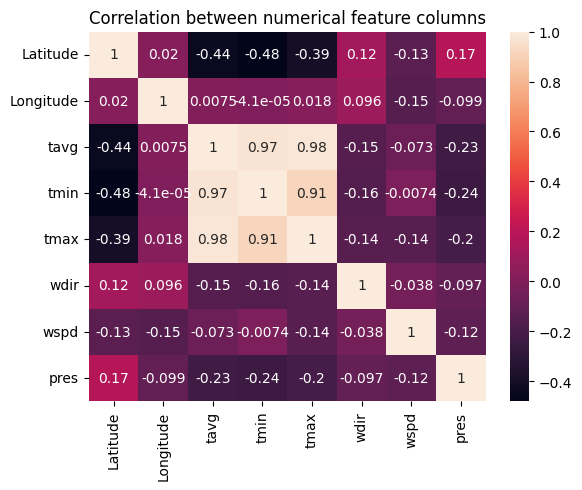

In [ ]:
import seaborn as sns

corr_feature_cols = ["Latitude", "Longitude", "tavg", "tmin", "tmax", "wdir", "wspd", "pres"]

sns.heatmap(corr_matrix_arr, annot = True, xticklabels = corr_feature_cols, yticklabels = corr_feature_cols)

plt.title("Correlation between numerical feature columns")
plt.show()

# Part 3: Analyze Hong Kong & Fiji wind speed and air pressure to see the frequency trend of the typhoons

## Hong Kong

In [ ]:
df_HK = df[df["country"] == "Hong Kong"]

In [ ]:
df_HK.describe().show()

+-------+---------+---------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|  country|     city|         Latitude|         Longitude|              tavg|              tmin|             tmax|              wdir|              wspd|              pres|
+-------+---------+---------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|     1677|     1677|             1677|              1677|              1677|              1677|             1677|              1677|              1677|              1677|
|   mean|     NULL|     NULL|22.39642800000001|114.10949700000025|24.553786523553978|22.322778771615983| 27.2251639833035|119.53488372093024|15.857304710793088|1012.4633273703042|
| stddev|     NULL|     NULL|              0.0|               0.0| 5.147116604569541| 5.225676113369

In [ ]:
df_HK.summary().show()

+-------+---------+---------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|  country|     city|         Latitude|         Longitude|              tavg|              tmin|             tmax|              wdir|              wspd|              pres|
+-------+---------+---------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|     1677|     1677|             1677|              1677|              1677|              1677|             1677|              1677|              1677|              1677|
|   mean|     NULL|     NULL|22.39642800000001|114.10949700000025|24.553786523553978|22.322778771615983| 27.2251639833035|119.53488372093024|15.857304710793088|1012.4633273703042|
| stddev|     NULL|     NULL|              0.0|               0.0| 5.147116604569541| 5.225676113369

In [ ]:
df_HK.show()

+----------+---------+---------+---------+----------+----+----+----+----+----+------+
|      date|  country|     city| Latitude| Longitude|tavg|tmin|tmax|wdir|wspd|  pres|
+----------+---------+---------+---------+----------+----+----+----+----+----+------+
|2018-01-01|Hong Kong|Hong Kong|22.396428|114.109497|17.5|16.4|19.6|  74|13.3|1020.3|
|2018-01-02|Hong Kong|Hong Kong|22.396428|114.109497|18.7|16.6|21.6|  90|15.0|1019.2|
|2018-01-04|Hong Kong|Hong Kong|22.396428|114.109497|20.1|18.6|22.6|  98|20.3|1016.4|
|2018-01-05|Hong Kong|Hong Kong|22.396428|114.109497|19.5|17.6|21.7|  62|11.9|1015.1|
|2018-01-06|Hong Kong|Hong Kong|22.396428|114.109497|16.7|15.8|17.6|  89|21.8|1014.6|
|2018-01-07|Hong Kong|Hong Kong|22.396428|114.109497|17.4|15.1|18.7|  82|22.5|1014.1|
|2018-01-08|Hong Kong|Hong Kong|22.396428|114.109497|15.3| 9.1|19.6|   8|24.7|1015.7|
|2018-01-09|Hong Kong|Hong Kong|22.396428|114.109497| 8.4| 7.1|10.6|  30|18.3|1023.9|
|2018-01-10|Hong Kong|Hong Kong|22.396428|114.109497|1

Calculate the mean and standard deviation for the columns `wspd` and `pres`



In [ ]:
from pyspark.sql.functions import mean, stddev_pop

mean_HK_wspd = df_HK.agg(mean("wspd")).collect()[0][0]
std_HK_wspd = df_HK.agg(stddev_pop("wspd")).collect()[0][0]

mean_HK_pres = df_HK.agg(mean("pres")).collect()[0][0]
std_HK_pres = df_HK.agg(stddev_pop("pres")).collect()[0][0]

In [ ]:
print("The mean of wind speed in Hong Kong from 2018 to 2022 is:", mean_HK_wspd, "km/h")
print("The standard deviation of wind speed in Hong Kong from 2018 to 2022 is:", std_HK_wspd, "km/h")

print("The mean of sea-level air pressure in Hong Kong from 2018 to 2022 is:", mean_HK_pres, "hPa")
print("The standard deviation of sea-level air pressure in Hong Kong from 2018 to 2022 is:", std_HK_pres, "hPa")

The mean of wind speed in Hong Kong from 2018 to 2022 is: 15.857304710793088 km/h
The standard deviation of wind speed in Hong Kong from 2018 to 2022 is: 5.107124527612803 km/h
The mean of sea-level air pressure in Hong Kong from 2018 to 2022 is: 1012.4633273703042 hPa
The standard deviation of sea-level air pressure in Hong Kong from 2018 to 2022 is: 6.465701197066822 hPa


2018-09-16 is the typhoon Mangkhut strikes Hong Kong

In [ ]:
df_HK[df_HK["date"] == "2018-09-16"].show()

+----------+---------+---------+---------+----------+----+----+----+----+----+-----+
|      date|  country|     city| Latitude| Longitude|tavg|tmin|tmax|wdir|wspd| pres|
+----------+---------+---------+---------+----------+----+----+----+----+----+-----+
|2018-09-16|Hong Kong|Hong Kong|22.396428|114.109497|26.9|23.1|32.7|  56|36.4|991.3|
+----------+---------+---------+---------+----------+----+----+----+----+----+-----+



We treat wind speed 1.5 times the standard deviation wind speed greater than the mean wind speed, AND air pressure 1.5 times the standard deviation air pressure smaller than the mean air pressure as the possible days the typhoon occur

In [ ]:
df_HK_possible_typhoons_date = df_HK[(df_HK["wspd"] >= mean_HK_wspd + 1.5*std_HK_wspd) & (df_HK["pres"] <= mean_HK_pres - 1.5*std_HK_pres)]

In [ ]:
from pyspark.sql.functions import year

df_HK_possible_typhoons_date = df_HK_possible_typhoons_date.withColumn("year", year(df_HK_possible_typhoons_date["date"]))

In [ ]:
df_HK_possible_typhoons_date.show()

+----------+---------+---------+---------+----------+----+----+----+----+----+------+----+
|      date|  country|     city| Latitude| Longitude|tavg|tmin|tmax|wdir|wspd|  pres|year|
+----------+---------+---------+---------+----------+----+----+----+----+----+------+----+
|2018-06-08|Hong Kong|Hong Kong|22.396428|114.109497|27.5|24.6|28.6| 131|24.7|1000.6|2018|
|2018-07-04|Hong Kong|Hong Kong|22.396428|114.109497|30.6|28.2|33.6| 207|23.6|1001.6|2018|
|2018-09-16|Hong Kong|Hong Kong|22.396428|114.109497|26.9|23.1|32.7|  56|36.4| 991.3|2018|
|2019-07-31|Hong Kong|Hong Kong|22.396428|114.109497|26.6|25.3|28.3|  79|30.5|1002.1|2019|
|2019-08-01|Hong Kong|Hong Kong|22.396428|114.109497|26.6|24.8|27.7| 102|33.4|1000.1|2019|
|2019-08-02|Hong Kong|Hong Kong|22.396428|114.109497|27.7|25.4|30.6| 104|25.8|1001.9|2019|
|2019-08-10|Hong Kong|Hong Kong|22.396428|114.109497|31.1|29.5|34.0| 220|28.9| 998.7|2019|
|2019-08-11|Hong Kong|Hong Kong|22.396428|114.109497|30.8|29.3|33.8| 222|29.0|1000.7|2019|

In [ ]:
typhoons_day_HK_by_year = df_HK_possible_typhoons_date.groupby("year").count().toPandas()

In [ ]:
typhoons_day_HK_by_year

,year,count
0,2018,3
1,2019,6
2,2021,3
3,2022,4


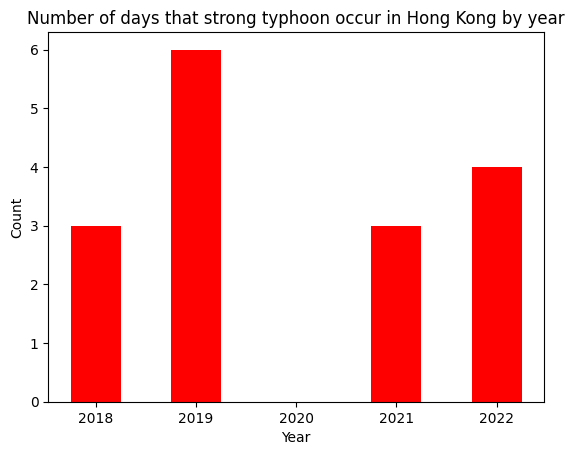

In [ ]:
import matplotlib.pyplot as plt

plt.bar(typhoons_day_HK_by_year["year"], typhoons_day_HK_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that strong typhoon occur in Hong Kong by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

In [ ]:
max_wspd_HK_by_year = df_HK_possible_typhoons_date.groupby("year").max().toPandas()

In [ ]:
max_wspd_HK_by_year

,year,max(Latitude),max(Longitude),max(tavg),max(tmin),max(tmax),max(wdir),max(wspd),max(pres),max(year)
0,2018,22.396428,114.109497,30.6,28.2,33.6,207,36.4,1001.6,2018
1,2019,22.396428,114.109497,31.2,29.5,34.0,224,33.4,1002.1,2019
2,2021,22.396428,114.109497,26.4,24.6,28.1,352,33.9,1002.7,2021
3,2022,22.396428,114.109497,29.3,28.6,31.6,200,43.4,1001.6,2022


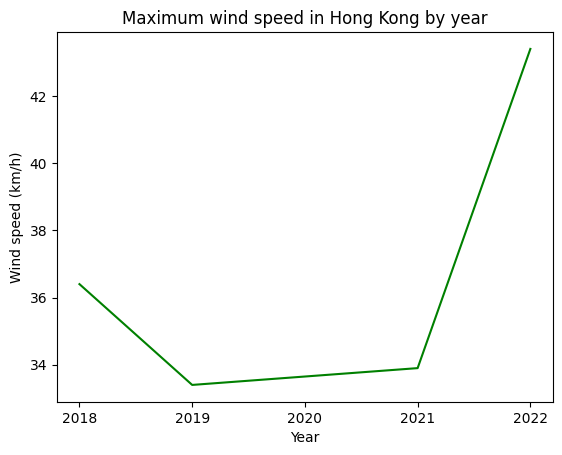

In [ ]:
plt.plot(max_wspd_HK_by_year["year"], max_wspd_HK_by_year["max(wspd)"], color = "green", linestyle = "-")

plt.title("Maximum wind speed in Hong Kong by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Wind speed (km/h)")

plt.show()

## Fiji

In [ ]:
df_Fiji = df[df["country"] == "Fiji"]

In [ ]:
df_Fiji.describe().show()

+-------+-------+----+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|country|city|           Latitude|         Longitude|              tavg|              tmin|              tmax|              wdir|              wspd|              pres|
+-------+-------+----+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|    816| 816|                816|               816|               816|               816|               816|               816|               816|               816|
|   mean|   NULL|NULL|-18.124809000000006|178.45007900000002|25.096568627450992|22.016666666666666| 28.98995098039215|127.49264705882354|10.088848039215685|1011.8251225490194|
| stddev|   NULL|NULL|                0.0|               0.0|  1.56654846742958|1.8315280198581612|2.0739984198274812|10

In [ ]:
df_Fiji.summary().show()

+-------+-------+----+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|country|city|           Latitude|         Longitude|              tavg|              tmin|              tmax|              wdir|              wspd|              pres|
+-------+-------+----+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|    816| 816|                816|               816|               816|               816|               816|               816|               816|               816|
|   mean|   NULL|NULL|-18.124809000000006|178.45007900000002|25.096568627450992|22.016666666666666| 28.98995098039215|127.49264705882354|10.088848039215685|1011.8251225490194|
| stddev|   NULL|NULL|                0.0|               0.0|  1.56654846742958|1.8315280198581612|2.0739984198274812|10

In [ ]:
df_Fiji.show()

+----------+-------+----+----------+----------+----+----+----+----+----+------+
|      date|country|city|  Latitude| Longitude|tavg|tmin|tmax|wdir|wspd|  pres|
+----------+-------+----+----------+----------+----+----+----+----+----+------+
|2018-01-21|   Fiji|Suva|-18.124809|178.450079|27.6|24.6|30.6| 118|14.3|1011.9|
|2018-01-22|   Fiji|Suva|-18.124809|178.450079|28.2|23.8|30.6| 115|13.2|1010.5|
|2018-02-09|   Fiji|Suva|-18.124809|178.450079|27.9|25.5|31.7| 249|15.8| 998.5|
|2018-02-12|   Fiji|Suva|-18.124809|178.450079|26.7|21.6|30.6| 272|10.1|1002.5|
|2018-02-15|   Fiji|Suva|-18.124809|178.450079|27.3|24.6|32.1|   5|15.1|1002.6|
|2018-04-01|   Fiji|Suva|-18.124809|178.450079|26.2|21.7|26.6|  27|20.8|1005.3|
|2018-04-15|   Fiji|Suva|-18.124809|178.450079|24.4|22.6|28.6| 126|13.2|1013.7|
|2018-04-17|   Fiji|Suva|-18.124809|178.450079|25.9|22.0|28.6| 117|17.2|1013.9|
|2018-04-25|   Fiji|Suva|-18.124809|178.450079|25.8|24.6|27.6| 112|12.7|1012.0|
|2018-06-30|   Fiji|Suva|-18.124809|178.

Calculate the mean and standard deviation for the columns `wspd` and `pres`



In [ ]:
from pyspark.sql.functions import mean, stddev_pop

mean_Fiji_wspd = df_Fiji.agg(mean("wspd")).collect()[0][0]
std_Fiji_wspd = df_Fiji.agg(stddev_pop("wspd")).collect()[0][0]

mean_Fiji_pres = df_Fiji.agg(mean("pres")).collect()[0][0]
std_Fiji_pres = df_Fiji.agg(stddev_pop("pres")).collect()[0][0]

In [ ]:
print("The mean of wind speed in Fiji from 2018 to 2022 is:", mean_Fiji_wspd, "km/h")
print("The standard deviation of wind speed in Fiji from 2018 to 2022 is:", std_Fiji_wspd, "km/h")

print("The mean of sea-level air pressure in Fiji from 2018 to 2022 is:", mean_Fiji_pres, "hPa")
print("The standard deviation of sea-level air pressure in Fiji from 2018 to 2022 is:", std_Fiji_pres, "hPa")

The mean of wind speed in Fiji from 2018 to 2022 is: 10.088848039215685 km/h
The standard deviation of wind speed in Fiji from 2018 to 2022 is: 4.045178156774454 km/h
The mean of sea-level air pressure in Fiji from 2018 to 2022 is: 1011.8251225490194 hPa
The standard deviation of sea-level air pressure in Fiji from 2018 to 2022 is: 3.7432741952290614 hPa


We treat wind speed 1.5 times the standard deviation wind speed greater than the mean wind speed, AND air pressure 1.5 times the standard deviation air pressure smaller than the mean air pressure as the possible days the typhoon occur

In [ ]:
df_Fiji_possible_typhoons_date = df_Fiji[(df_Fiji["wspd"] >= mean_Fiji_wspd + 1.5*std_Fiji_wspd) & (df_Fiji["pres"] <= mean_Fiji_pres - 1.5*std_Fiji_pres)]

In [ ]:
from pyspark.sql.functions import year

df_Fiji_possible_typhoons_date = df_Fiji_possible_typhoons_date.withColumn("year", year(df_Fiji_possible_typhoons_date["date"]))

In [ ]:
df_Fiji_possible_typhoons_date.show()

+----------+-------+----+----------+----------+----+----+----+----+----+------+----+
|      date|country|city|  Latitude| Longitude|tavg|tmin|tmax|wdir|wspd|  pres|year|
+----------+-------+----+----------+----------+----+----+----+----+----+------+----+
|2018-04-01|   Fiji|Suva|-18.124809|178.450079|26.2|21.7|26.6|  27|20.8|1005.3|2018|
|2019-12-27|   Fiji|Suva|-18.124809|178.450079|26.5|23.6|26.6|  67|34.8|1003.4|2019|
|2019-12-30|   Fiji|Suva|-18.124809|178.450079|26.0|23.6|28.6| 235|19.9|1003.2|2019|
|2020-02-14|   Fiji|Suva|-18.124809|178.450079|28.1|25.7|30.6|  89|17.1|1005.2|2020|
|2020-12-18|   Fiji|Suva|-18.124809|178.450079|25.2|21.1|26.6| 194|22.1|1000.9|2020|
|2021-01-30|   Fiji|Suva|-18.124809|178.450079|26.2|23.0|30.8|  33|20.3| 999.1|2021|
|2021-01-31|   Fiji|Suva|-18.124809|178.450079|26.9|23.5|28.6|  31|46.6| 987.8|2021|
|2022-01-09|   Fiji|Suva|-18.124809|178.450079|24.4|23.1|25.1|  21|18.7|1004.8|2022|
|2022-01-10|   Fiji|Suva|-18.124809|178.450079|26.3|22.9|30.0|   

In [ ]:
typhoons_day_Fiji_by_year = df_Fiji_possible_typhoons_date.groupby("year").count().toPandas()

In [ ]:
typhoons_day_Fiji_by_year

,year,count
0,2018,1
1,2019,2
2,2020,2
3,2021,2
4,2022,3


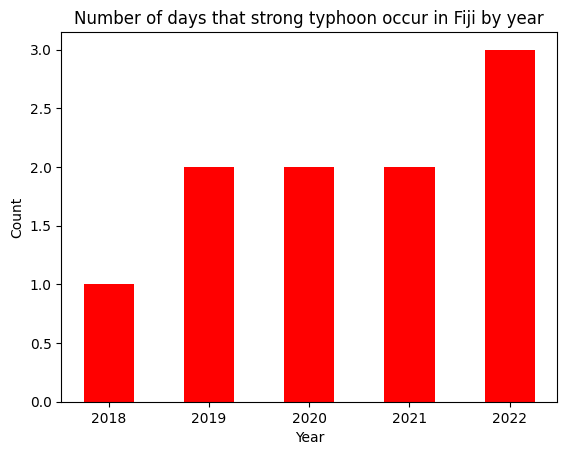

In [ ]:
import matplotlib.pyplot as plt

plt.bar(typhoons_day_Fiji_by_year["year"], typhoons_day_Fiji_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that strong typhoon occur in Fiji by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

In [ ]:
max_wspd_Fiji_by_year = df_Fiji_possible_typhoons_date.groupby("year").max().toPandas()

In [ ]:
max_wspd_Fiji_by_year

,year,max(Latitude),max(Longitude),max(tavg),max(tmin),max(tmax),max(wdir),max(wspd),max(pres),max(year)
0,2018,-18.124809,178.450079,26.2,21.7,26.6,27,20.8,1005.3,2018
1,2019,-18.124809,178.450079,26.5,23.6,28.6,235,34.8,1003.4,2019
2,2020,-18.124809,178.450079,28.1,25.7,30.6,194,22.1,1005.2,2020
3,2021,-18.124809,178.450079,26.9,23.5,30.8,33,46.6,999.1,2021
4,2022,-18.124809,178.450079,26.5,23.5,30.0,21,22.3,1004.8,2022


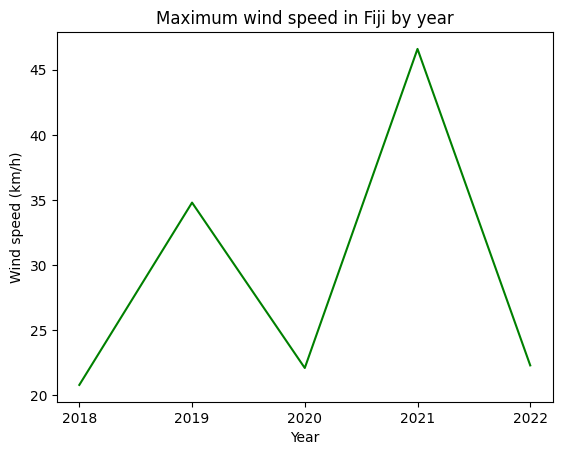

In [ ]:
plt.plot(max_wspd_Fiji_by_year["year"], max_wspd_Fiji_by_year["max(wspd)"], color = "green", linestyle = "-")

plt.title("Maximum wind speed in Fiji by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Wind speed (km/h)")

plt.show()

# Part 4: Linear Regression

In [9]:
import numpy as np
import matplotlib.ticker as ticker
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression,LinearRegressionModel,RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp,to_date,col, udf,year,month
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
from datetime import datetime
def showPlt(col1,col2):
  data=df.select(col1,col2).rdd.filter(lambda row: row[col1] is not None and row[col2] is not None).sample(False, 0.01).map(lambda row: (float(row[col1]), float(row[col2]))).toDF([col1, col2]).toPandas()
  plt.scatter(data[col1],data[col2])
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.xticks(rotation=45)
  plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(10))
  plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
  plt.show()

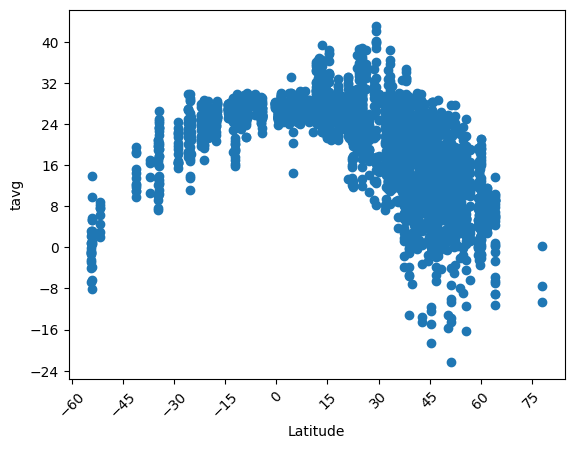

In [ ]:
showPlt('Latitude','tavg')

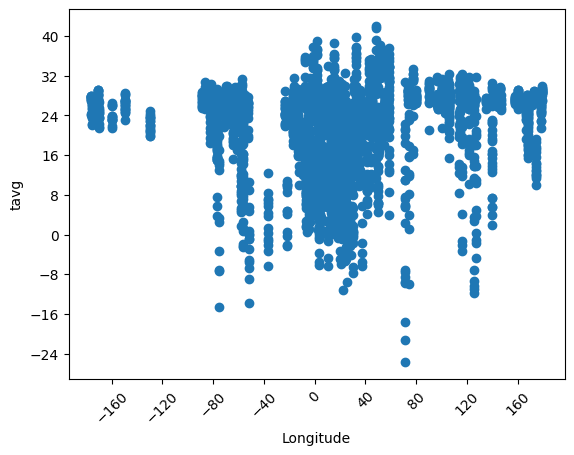

In [ ]:
showPlt('Longitude','tavg')

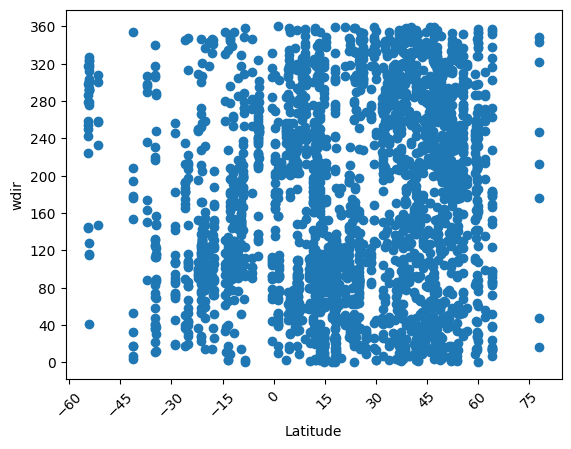

In [ ]:
showPlt('Latitude','wdir')

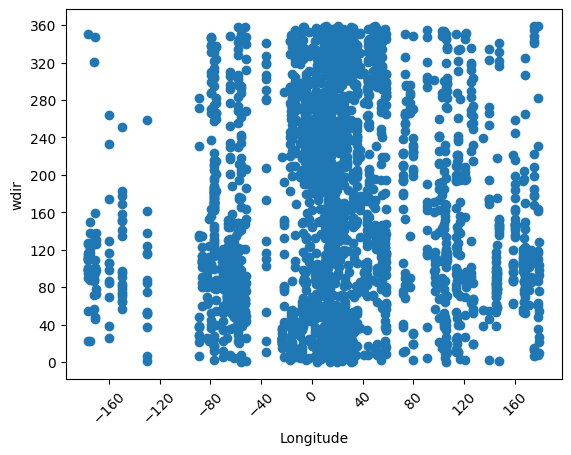

In [ ]:
showPlt('Longitude','wdir')

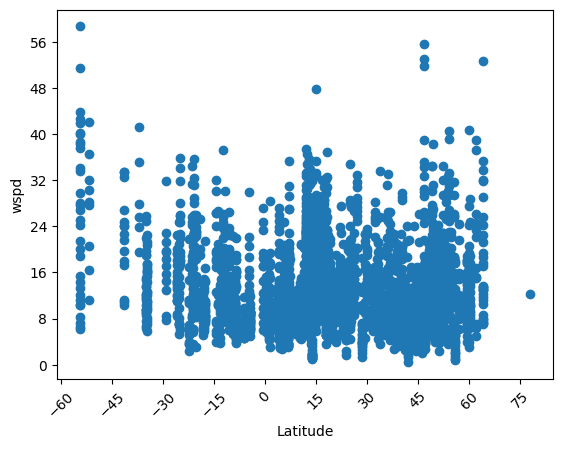

In [ ]:
showPlt('Latitude','wspd')

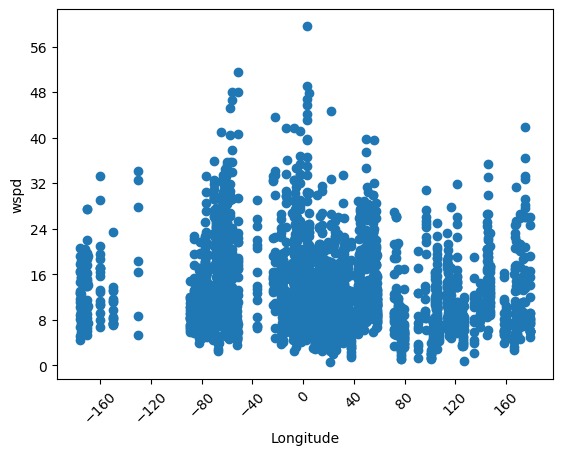

In [ ]:
showPlt('Longitude','wspd')

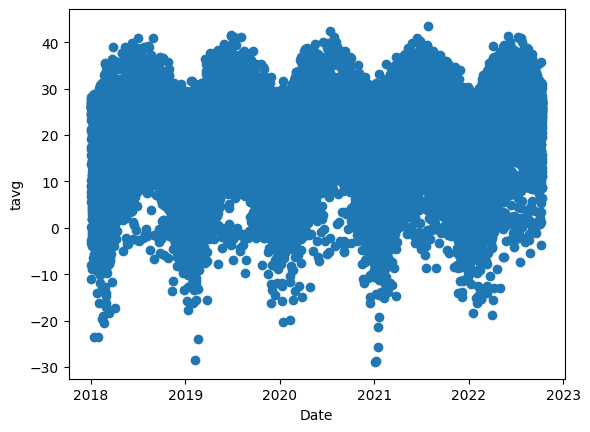

In [ ]:
from datetime import datetime
#data = df.select('Date', 'tavg').filter((col('Date').isNotNull()) & (col('tavg').isNotNull())).sample(fraction=0.01, seed=4651).rdd.map(lambda row: (datetime.strptime(row['Date'],'%d-%m-%Y'), float(row['tavg']))).toDF(['Date', 'tavg']).toPandas()
data = df.select('Date', 'tavg').rdd.filter(lambda row: row['Date'] is not None and row['tavg'] is not None).sample(False, 0.1).map(lambda row: (datetime.strptime(row['Date'], '%d-%m-%Y'), float(row['tavg']))).toDF(['Date', 'tavg']).toPandas()
plt.scatter(data['Date'], data['tavg'])
plt.xlabel('Date')
plt.ylabel('tavg')
plt.show()

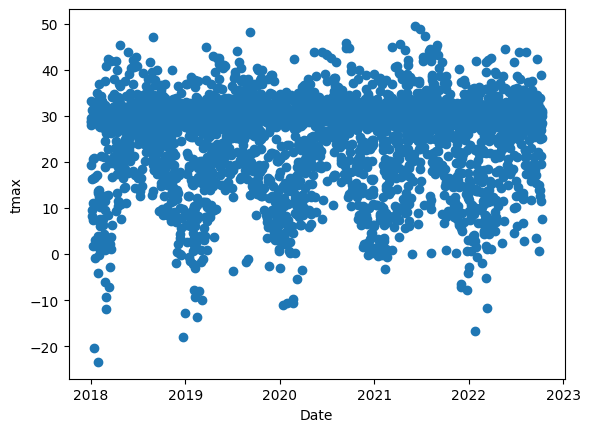

In [ ]:
data = df.select('Date', 'tmax').rdd.filter(lambda row: row['Date'] is not None and row['tmax'] is not None).sample(False, 0.01).map(lambda row: (datetime.strptime(row['Date'],'%d-%m-%Y'), float(row['tmax']))).toDF(['Date', 'tmax']).toPandas()
plt.scatter(data['Date'], data['tmax'])
plt.xlabel('Date')
plt.ylabel('tmax')
plt.show()

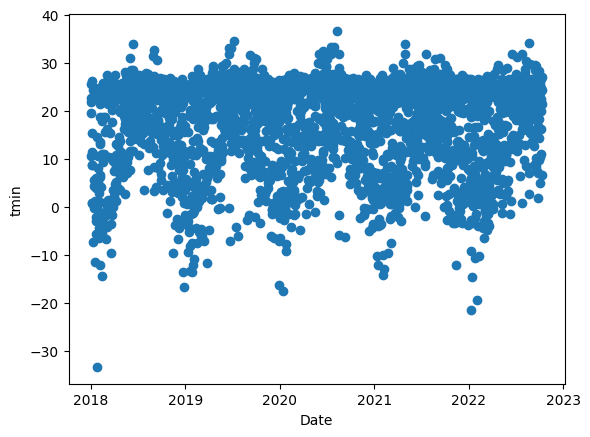

In [ ]:
data = df.select('Date', 'tmin').rdd.filter(lambda row: row['Date'] is not None and row['tmin'] is not None).sample(False, 0.01).map(lambda row: (datetime.strptime(row['Date'],'%d-%m-%Y'), float(row['tmin']))).toDF(['Date', 'tmin']).toPandas()
plt.scatter(data['Date'], data['tmin'])
plt.xlabel('Date')
plt.ylabel('tmin')
plt.show()

#### Start linear regression

InputCol latitude, longtitude, date, wspd, wdir, pressure \
label col tavg

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression,LinearRegressionModel,RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp,to_date,col, udf,year,month
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
regEval = RegressionEvaluator(predictionCol="Prediction_tavg", labelCol="tavg", metricName="rmse")
vectorizer = VectorAssembler()
df=spark.read.option("header", True).csv(file_path)
mlDF=df

In [ ]:
df.count()

324647

In [ ]:
feature_columns = ["Latitude", "Longitude", "wdir", "wspd", "pres", "date"]
vectorizer.setInputCols(feature_columns)
vectorizer.setOutputCol("features")
seed=4651
mlDF=mlDF.withColumn("Latitude", col("Latitude").cast("float"))
mlDF=mlDF.withColumn("Longitude", col("Longitude").cast("float"))
mlDF=mlDF.withColumn("wdir", col("wdir").cast("float"))
mlDF=mlDF.withColumn("wspd", col("wspd").cast("float"))
mlDF=mlDF.withColumn("pres", col("pres").cast("float"))
mlDF=mlDF.withColumn("date", unix_timestamp(col("date"), "dd-MM-yyyy"))
mlDF=mlDF.withColumn("tavg", col("tavg").cast("float"))
mlDF=mlDF.dropna(how="any")
(split15DF, split85DF) = mlDF.randomSplit([0.15,0.85],seed)
# Let's cache these datasets for performance
testSetDF = split15DF.cache()
trainingSetDF = split85DF.cache()

In [ ]:
mlDF.count()

277551

In [ ]:
testSetDF.count()

41744

In [ ]:
trainingSetDF.count()

235807

In [ ]:
mlDF.take(5)

[Row(date=1532131200, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=23.399999618530273, tmin='20.9', tmax='25.5', wdir=329.0, wspd=9.300000190734863, pres=1009.5999755859375),
 Row(date=1532217600, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=23.5, tmin='21', tmax='25.7', wdir=337.0, wspd=9.399999618530273, pres=1010.0),
 Row(date=1532304000, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=23.5, tmin='21.1', tmax='25.5', wdir=41.0, wspd=8.199999809265137, pres=1007.7000122070312),
 Row(date=1532390400, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=24.299999237060547, tmin='20.8', tmax='27.1', wdir=10.0, wspd=9.300000190734863, pres=1004.4000244140625),
 Row(date=1532476800, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=26.5, t

In [ ]:
lr = LinearRegression()
lr.setPredictionCol("Prediction_tavg")\
  .setLabelCol("tavg")\
  .setMaxIter(100)\
  .setRegParam(0.15)
lrPipeline = Pipeline()
lrPipeline.setStages([vectorizer, lr])
lrModel = lrPipeline.fit(trainingSetDF)

In [ ]:
resultsDF = lrModel.transform(testSetDF).select("Latitude", "Longitude", "wdir", "wspd", "pres", "date","Prediction_tavg","tavg")
rmse = regEval.evaluate(resultsDF)
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 8.03


In [ ]:
resultsDF.select("Prediction_tavg","tavg").toPandas()

,Prediction_tavg,tavg
0,17.246333,5.900000
1,25.550981,27.799999
2,11.940872,14.100000
3,17.116802,-11.100000
4,12.164121,9.200000
...,...,...
41739,25.790710,26.500000
41740,21.219198,28.200001
41741,26.177098,26.900000
41742,27.568458,27.200001


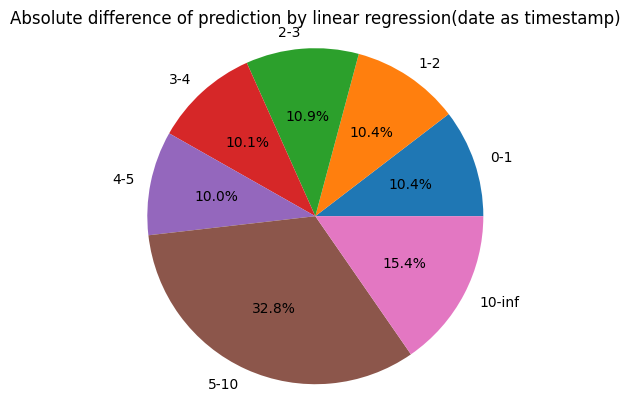

{'0-1': 4342, '1-2': 4355, '2-3': 4531, '3-4': 4218, '4-5': 4183, '5-10': 13702, '10-inf': 6413}


In [ ]:
df_pandas = resultsDF.select("Prediction_tavg", "tavg").toPandas()
df_pandas['difference'] = abs(df_pandas['Prediction_tavg'] - df_pandas['tavg'])
ranges = {'0-1': (0, 1), '1-2': (1, 2),'2-3': (2, 3),'3-4': (3, 4),'4-5': (4, 5), '5-10': (5, 10), '10-inf': (10, float('inf'))}
range_counts = {key: len(df_pandas[(df_pandas['difference'] > value[0]) & (df_pandas['difference'] <= value[1])]) for key, value in ranges.items()}
plt.pie(range_counts.values(), labels=range_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Absolute difference of prediction by linear regression(date as timestamp)')
plt.show()
print(range_counts)

#### Instead of encoding the date into timestamp, maybe we should use month

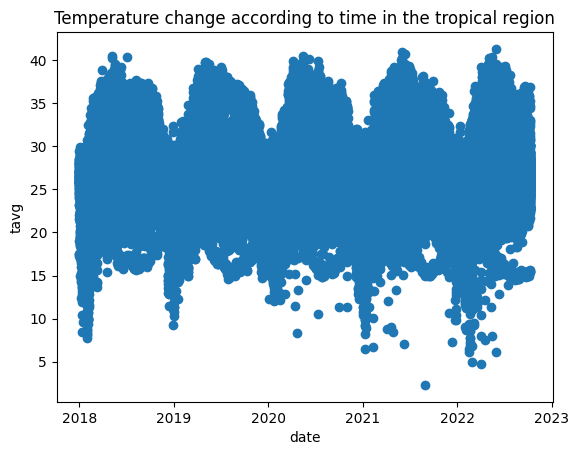

date    159543
tavg    159543
dtype: int64


In [ ]:
data=df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (-23.5 <= float(row['Latitude']) <= 23.5)).map(lambda row: {'date':datetime.strptime(row['date'],'%d-%m-%Y'),'Latitude':float(row['Latitude']), 'tavg':float(row['tavg'])}).toDF().select('date','tavg').toPandas()
plt.scatter(data['date'], data['tavg'])
plt.xlabel('date')
plt.ylabel('tavg')
plt.title("Temperature change according to time in the tropical region")
plt.show()
print(data.count())

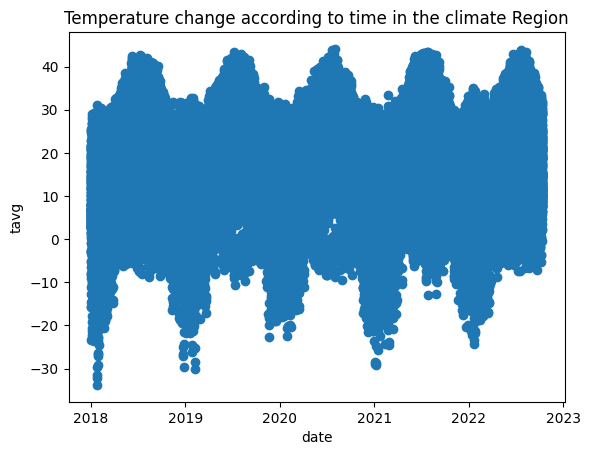

date    154731
tavg    154731
dtype: int64


In [ ]:
data=df.select('date','tavg','Latitude').rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and ((-23.5 > float(row['Latitude']) > -66.5) or (23.5 < float(row['Latitude']) < 66.5))).map(lambda row: {'date':datetime.strptime(row['date'],'%d-%m-%Y'),'Latitude':float(row['Latitude']), 'tavg':float(row['tavg'])}).toDF().select('date','tavg').toPandas()
plt.scatter(data['date'], data['tavg'])
plt.xlabel('date')
plt.ylabel('tavg')
plt.title("Temperature change according to time in the climate Region")
plt.show()
print(data.count())

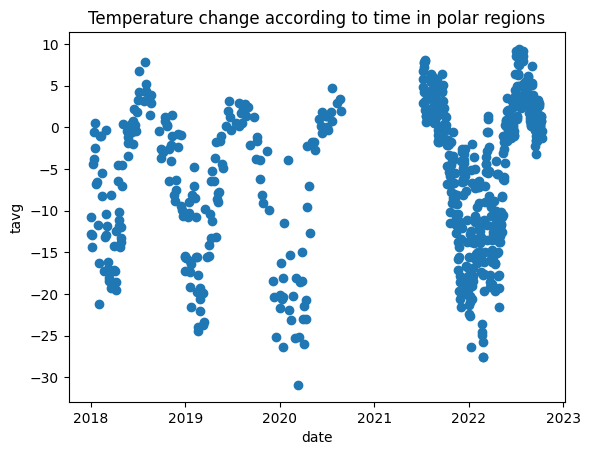

date    689
tavg    689
dtype: int64


In [ ]:
data=df.select('date','tavg','Latitude').rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (float(row['Latitude']) >= 66.5 or float(row['Latitude']) <= -66.5)).map(lambda row: {'date':datetime.strptime(row['date'],'%d-%m-%Y'),'Latitude':float(row['Latitude']), 'tavg':float(row['tavg'])}).toDF().select('date','tavg').toPandas()
plt.scatter(data['date'], data['tavg'])
plt.xlabel('date')
plt.ylabel('tavg')
plt.title("Temperature change according to time in polar regions")
plt.show()
print(data.count())

In [ ]:
mldf2=df
mldf2=mldf2.withColumn("Latitude", col("Latitude").cast("float"))
mldf2=mldf2.withColumn("Longitude", col("Longitude").cast("float"))
mldf2=mldf2.withColumn("wdir", col("wdir").cast("float"))
mldf2=mldf2.withColumn("wspd", col("wspd").cast("float"))
mldf2=mldf2.withColumn("pres", col("pres").cast("float"))
mldf2=mldf2.withColumn("tavg", col("tavg").cast("float"))
mldf2=mldf2.withColumn("date", to_date(col("date"), "dd-MM-yyyy"))
mldf2=mldf2.withColumn("date", month(col("date")))
print(mldf2.take(1))
mldf2=mldf2.dropna(how="any")
(split15DF, split85DF) = mldf2.randomSplit([0.15,0.85],seed)
# Let's cache these datasets for performance
testSetDF2 = split15DF.cache()
trainingSetDF2 = split85DF.cache()

[Row(date=7, country='Abkhazia', city='Sukhumi', Latitude=43.00152587890625, Longitude=41.023414611816406, tavg=23.399999618530273, tmin='20.9', tmax='25.5', wdir=329.0, wspd=9.300000190734863, pres=1009.5999755859375)]


In [ ]:
lrModel = lrPipeline.fit(trainingSetDF2)
resultsDF2 = lrModel.transform(testSetDF2).select("Latitude", "Longitude", "wdir", "wspd", "pres", "date","Prediction_tavg","tavg")
rmse = regEval.evaluate(resultsDF2)
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 7.99


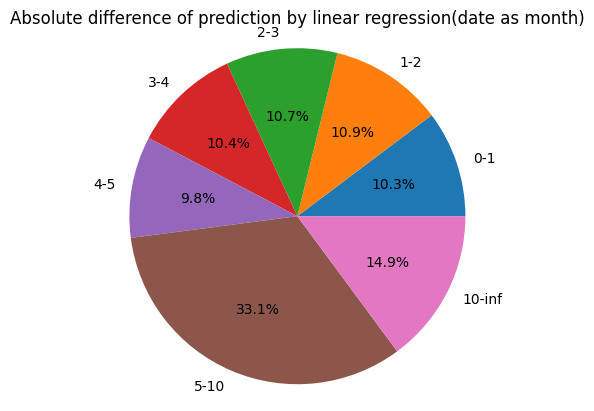

{'0-1': 4286, '1-2': 4550, '2-3': 4472, '3-4': 4346, '4-5': 4080, '5-10': 13800, '10-inf': 6210}


In [ ]:
df_pandas = resultsDF2.select("Prediction_tavg", "tavg").toPandas()
df_pandas['difference'] = abs(df_pandas['Prediction_tavg'] - df_pandas['tavg'])
ranges = {'0-1': (0, 1), '1-2': (1, 2),'2-3': (2, 3),'3-4': (3, 4),'4-5': (4, 5), '5-10': (5, 10), '10-inf': (10, float('inf'))}
range_counts = {key: len(df_pandas[(df_pandas['difference'] > value[0]) & (df_pandas['difference'] <= value[1])]) for key, value in ranges.items()}
plt.pie(range_counts.values(), labels=range_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Absolute difference of prediction by linear regression(date as month)')
plt.show()
print(range_counts)

In [ ]:
# Create a RandomForestRegressor
rf = RandomForestRegressor()

rf.setPredictionCol("Prediction_tavg").setLabelCol("tavg").setFeaturesCol("features").setSeed(190088121).setMaxDepth(8).setNumTrees(25)

# Create a Pipeline
rfPipeline = Pipeline()

# Set the stages of the Pipeline
rfPipeline.setStages([vectorizer,rf])

Pipeline_d09365d9a5cb

In [ ]:
rfModel = rfPipeline.fit(trainingSetDF)
resultsDF3 = rfModel.transform(testSetDF).select("Latitude", "Longitude", "wdir", "wspd", "pres", "date","Prediction_tavg","tavg")
rmse = regEval.evaluate(resultsDF3)
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 4.46


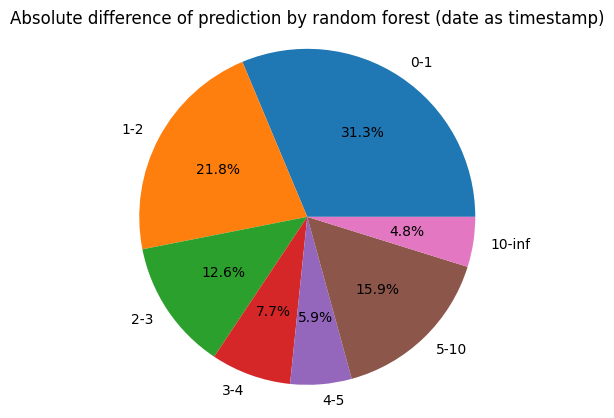

{'0-1': 13069, '1-2': 9096, '2-3': 5239, '3-4': 3222, '4-5': 2463, '5-10': 6646, '10-inf': 2009}


In [ ]:
df_pandas = resultsDF3.select("Prediction_tavg", "tavg").toPandas()
df_pandas['difference'] = abs(df_pandas['Prediction_tavg'] - df_pandas['tavg'])
ranges = {'0-1': (0, 1), '1-2': (1, 2),'2-3': (2, 3),'3-4': (3, 4),'4-5': (4, 5), '5-10': (5, 10), '10-inf': (10, float('inf'))}
range_counts = {key: len(df_pandas[(df_pandas['difference'] > value[0]) & (df_pandas['difference'] <= value[1])]) for key, value in ranges.items()}
plt.pie(range_counts.values(), labels=range_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Absolute difference of prediction by random forest (date as timestamp)')
plt.show()
print(range_counts)

In [ ]:
rfModel = rfPipeline.fit(trainingSetDF2)
resultsDF4 = rfModel.transform(testSetDF2).select("Latitude", "Longitude", "wdir", "wspd", "pres", "date","Prediction_tavg","tavg")
rmse = regEval.evaluate(resultsDF4)
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 3.35


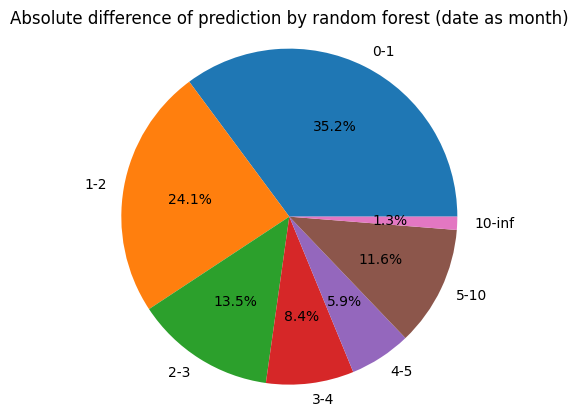

{'0-1': 14676, '1-2': 10068, '2-3': 5634, '3-4': 3524, '4-5': 2476, '5-10': 4838, '10-inf': 528}


In [ ]:
df_pandas = resultsDF4.select("Prediction_tavg", "tavg").toPandas()
df_pandas['difference'] = abs(df_pandas['Prediction_tavg'] - df_pandas['tavg'])
ranges = {'0-1': (0, 1), '1-2': (1, 2),'2-3': (2, 3),'3-4': (3, 4),'4-5': (4, 5), '5-10': (5, 10), '10-inf': (10, float('inf'))}
range_counts = {key: len(df_pandas[(df_pandas['difference'] > value[0]) & (df_pandas['difference'] <= value[1])]) for key, value in ranges.items()}
plt.pie(range_counts.values(), labels=range_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Absolute difference of prediction by random forest (date as month)')
plt.show()
print(range_counts)

# Global warming

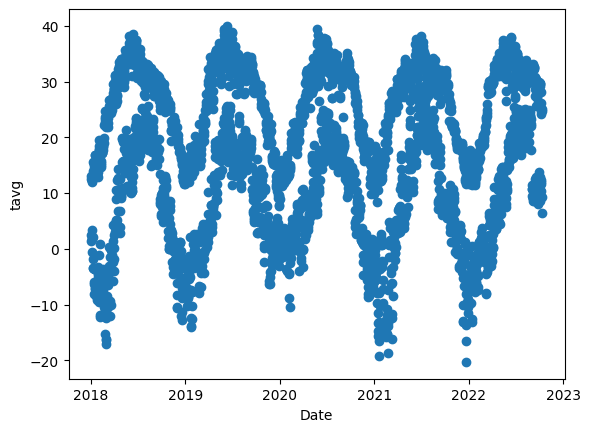

In [13]:
from datetime import datetime
from pyspark.sql.functions import unix_timestamp,to_date,col, udf,year,month
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
import seaborn as sns
data = df.select('Date', 'tavg','country').rdd.filter(lambda row: row['Date'] is not None and row['tavg'] is not None and row['country']in['Russia','India']).map(lambda row: (datetime.strptime(row['Date'], '%d-%m-%Y'), float(row['tavg']))).toDF(['Date', 'tavg']).toPandas()
plt.scatter(data['Date'], data['tavg'])
plt.xlabel('Date')
plt.ylabel('tavg')
plt.show()

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and row['country'] in ['Russia','Japan','Hong Kong']) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year, row['country']), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0][0], 'Country': x[0][1], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Country'), col('Year'))

In [ ]:
data.toPandas()

,Country,Year,avg_tavg
0,Hong Kong,2018,24.064286
1,Hong Kong,2019,24.774795
2,Hong Kong,2020,24.447268
3,Hong Kong,2021,24.586849
4,Hong Kong,2022,24.783803
5,Japan,2018,16.441096
6,Japan,2019,16.110959
7,Japan,2020,16.159016
8,Japan,2021,16.261370
9,Japan,2022,17.269014


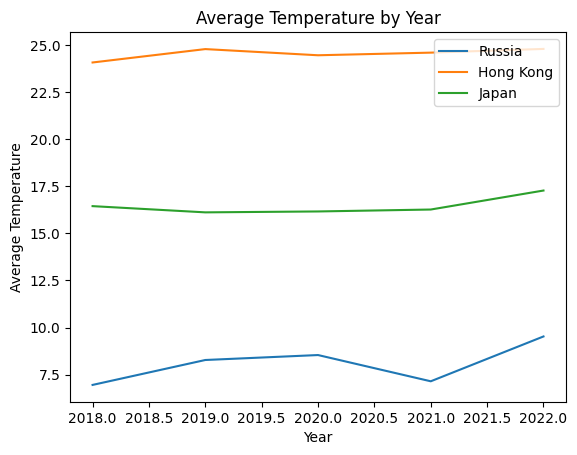

In [ ]:
grouped_data = data.groupby('Country').agg({'Year': 'collect_list', 'avg_tavg': 'collect_list'}).collect()

# Plot the lines for each country
for row in grouped_data:
    country = row['Country']
    years = row['collect_list(Year)']
    avg_temps = row['collect_list(avg_tavg)']
    plt.plot(years, avg_temps, label=country)

# Set the x-axis label and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Average Temperature by Year')

# Show a legend for the countries
plt.legend()

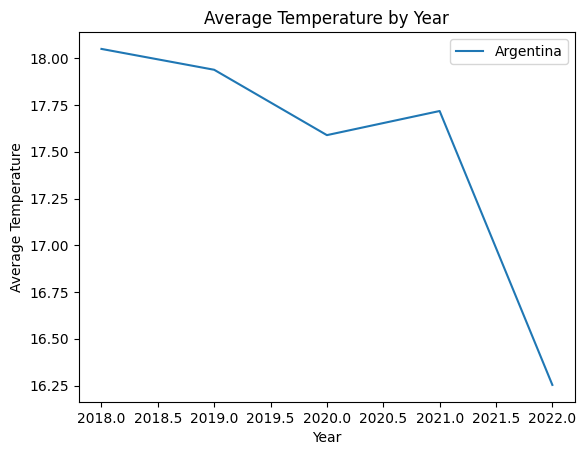

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and row['country'] in ['Argentina']) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year, row['country']), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0][0], 'Country': x[0][1], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Country'), col('Year'))
grouped_data = data.groupby('Country').agg({'Year': 'collect_list', 'avg_tavg': 'collect_list'}).collect()

# Plot the lines for each country
for row in grouped_data:
    country = row['Country']
    years = row['collect_list(Year)']
    avg_temps = row['collect_list(avg_tavg)']
    plt.plot(years, avg_temps, label=country)

# Set the x-axis label and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Average Temperature by Year')

# Show a legend for the countries
plt.legend()

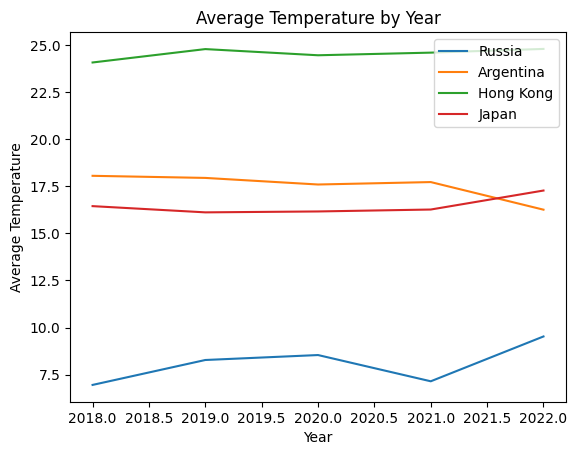

In [10]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and row['country'] in ['Argentina','Russia','Japan','Hong Kong']) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year, row['country']), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0][0], 'Country': x[0][1], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Country'), col('Year'))
grouped_data = data.groupby('Country').agg({'Year': 'collect_list', 'avg_tavg': 'collect_list'}).collect()

# Plot the lines for each country
for row in grouped_data:
    country = row['Country']
    years = row['collect_list(Year)']
    avg_temps = row['collect_list(avg_tavg)']
    plt.plot(years, avg_temps, label=country)

# Set the x-axis label and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Average Temperature by Year')

# Show a legend for the countries
plt.legend()

In [11]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['avg_tavg']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

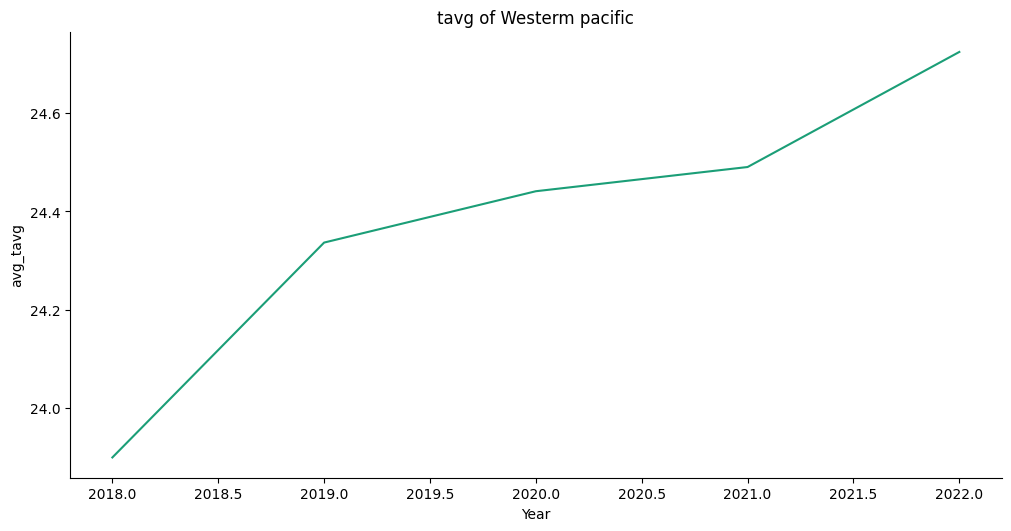

In [ ]:
data= df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (100 <= float(row['Longitude']) <= 180)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()



fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.title("tavg of Westerm pacific")
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')

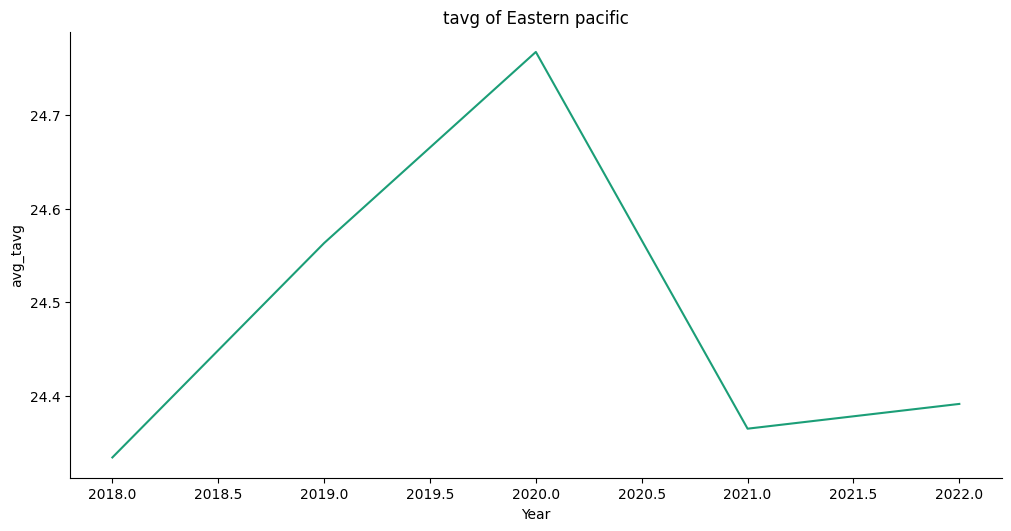

In [ ]:
data= df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (-170 <= float(row['Longitude']) <= -65)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.title("tavg of Eastern pacific")
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')


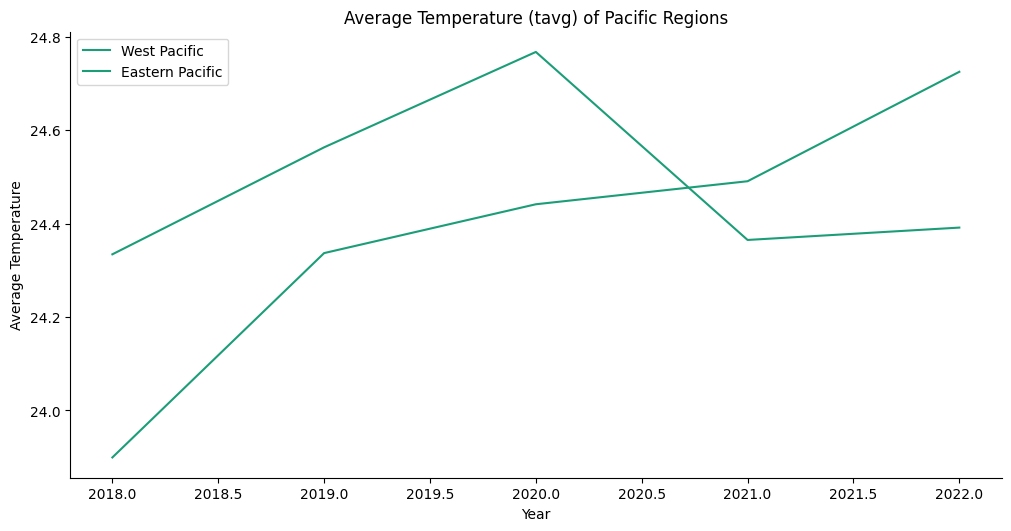

In [17]:
def _plot_series2(series, series_name, series_index=0, ax=None):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Year']
    ys = series['avg_tavg']
    ax.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

data1 = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (-170 <= float(row['Longitude']) <= -65)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()

data2 = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (100 <= float(row['Longitude']) <= 180)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted1 = data1.sort_values('Year', ascending=True)
df_sorted2 = data2.sort_values('Year', ascending=True)
_plot_series2(df_sorted1, 'West Pacific', ax=ax)
_plot_series2(df_sorted2, 'Eastern Pacific', ax=ax)
sns.despine(fig=fig, ax=ax)
plt.title("Average Temperature (tavg) of Pacific Regions")
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()

Try all the country

Text(0, 0.5, 'Average Temperature')

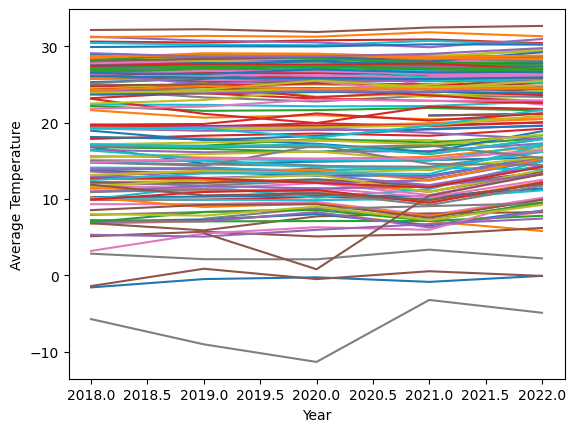

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year, row['country']), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0][0], 'Country': x[0][1], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Country'), col('Year'))

grouped_data = data.groupby('Country').agg({'Year': 'collect_list', 'avg_tavg': 'collect_list'}).collect()
# Plot the lines for each country
for row in grouped_data:
    country = row['Country']
    years = row['collect_list(Year)']
    avg_temps = row['collect_list(avg_tavg)']
    plt.plot(years, avg_temps, label=country)

# Set the x-axis label and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')


#### showing the average temperature by year and sum up all the country

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()
data

,Year,avg_tavg
0,2018,20.771823
1,2019,20.987103
2,2020,21.094040
3,2021,20.903980
4,2022,21.414004


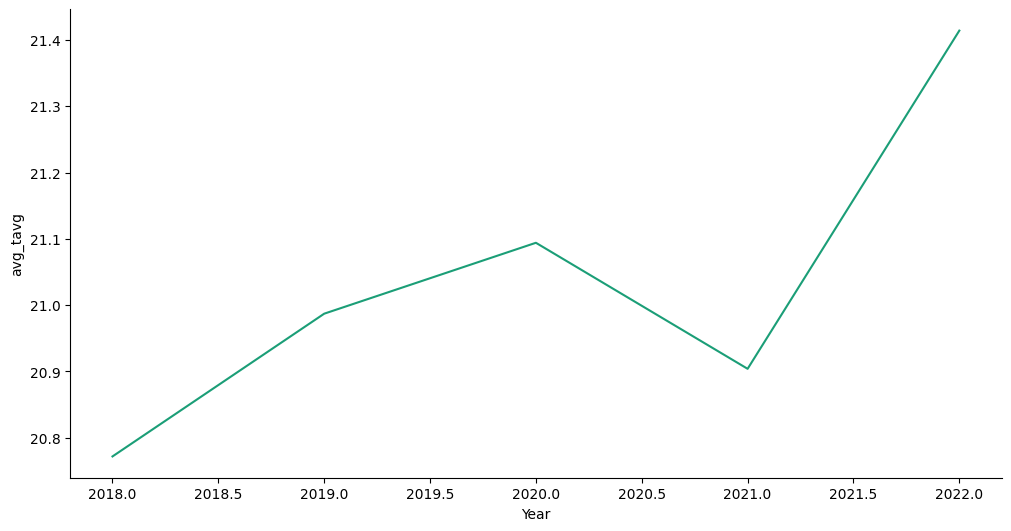

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['avg_tavg']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')

#### getting the tropical region only

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (-23.5 <= float(row['Latitude']) <= 23.5)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()
data

,Year,avg_tavg
0,2018,26.737310
1,2019,26.965358
2,2020,26.985690
3,2021,26.722727
4,2022,26.604499


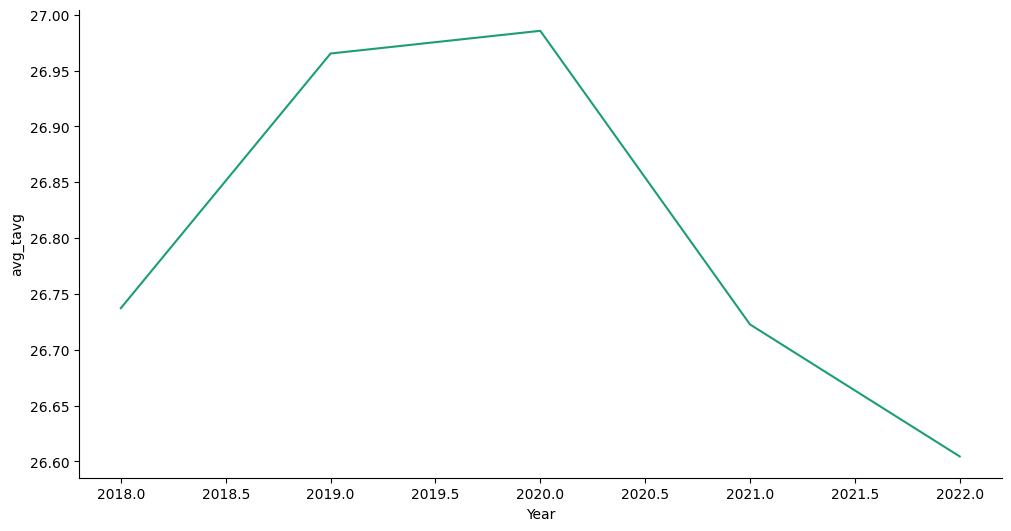

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')

#### region near the south pole and north pole

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and (float(row['Latitude']) >= 66.5 or float(row['Latitude']) <= -66.5)) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()
data

,Year,avg_tavg
0,2018,-5.753333
1,2019,-9.058442
2,2020,-11.363043
3,2021,-3.243017
4,2022,-4.924468


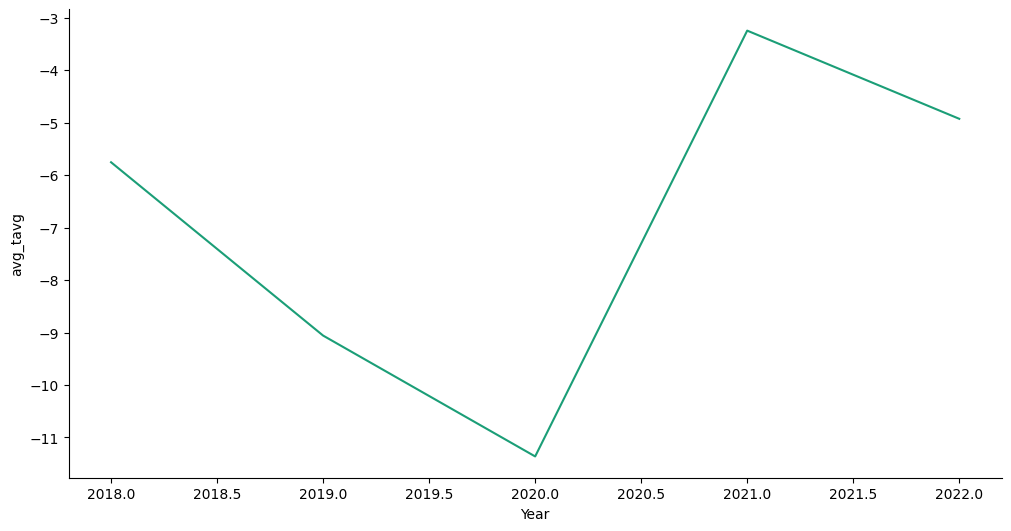

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')

#### Temperate climate Region

In [ ]:
data = df.rdd.filter(lambda row: row['date'] is not None and row['tavg'] is not None and ((-23.5 > float(row['Latitude']) > -66.5) or (23.5 < float(row['Latitude']) < 66.5))) \
    .map(lambda row: ((datetime.strptime(row['date'], '%d-%m-%Y').year), float(row['tavg']))) \
    .combineByKey(lambda tavg: (tavg, 1),
                 lambda first, new: (first[0] + new, first[1] + 1),
                 lambda first, second: (first[0] + second[0], first[1] + second[1])) \
    .map(lambda x: {'Year': x[0], 'avg_tavg': x[1][0] / x[1][1]}) \
    .toDF() \
    .orderBy(col('Year')).toPandas()
data

,Year,avg_tavg
0,2018,15.051172
1,2019,15.008287
2,2020,15.091341
3,2021,14.789897
4,2022,16.131894


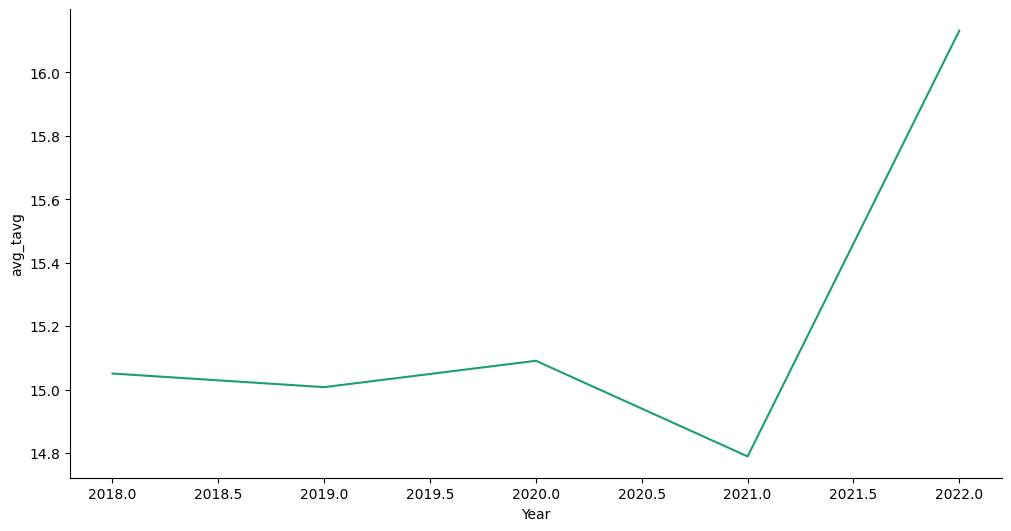

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('avg_tavg')

# Extreme Temperature

## Extreme Cold Weather

### Weather in Polar Region Cities

In [ ]:
import pyspark.sql.functions as F


df_Greenland = df[df["country"] == "Greenland"]

mean_Greenland_tavg = df_Greenland.agg(mean("tavg")).collect()[0][0]
std_Greenland_tavg = df_Greenland.agg(stddev_pop("tavg")).collect()[0][0]

mean_Greenland_tmin = df_Greenland.agg(mean("tmin")).collect()[0][0]
std_Greenland_tmin = df_Greenland.agg(stddev_pop("tmin")).collect()[0][0]

mean_Greenland_tmax = df_Greenland.agg(mean("tmax")).collect()[0][0]
std_Greenland_tmax = df_Greenland.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tavg, "°C")
print("The standard deviation of temperature in Greenland from 2018 to 2022 is:", std_Greenland_tavg, "°C")

print("The mean of min temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tmin, "°C")
print("The standard deviation of min temperature in Greenland from 2018 to 2022 is:", std_Greenland_tmin, "°C")

print("The mean of max temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tmax, "°C")
print("The standard deviation of max temperature in Greenland from 2018 to 2022 is:", std_Greenland_tmax, "°C")

df_Greenland_extreme_cold = df_Greenland[(df_Greenland["tmin"] <= mean_Greenland_tavg - 1.5*std_Greenland_tavg)]



df_Greenland_extreme_cold = df_Greenland_extreme_cold.withColumn("year", year(F.to_date(df_Greenland_extreme_cold["date"], "dd-MM-yyyy")))

extreme_cold_day_Greenland_by_year = df_Greenland_extreme_cold.groupby("year").count().toPandas()

extreme_cold_day_Greenland_by_year

The mean of temperature in Greenland from 2018 to 2022 is: -0.015748963883955087 °C
The standard deviation of temperature in Greenland from 2018 to 2022 is: 6.888763517856457 °C
The mean of min temperature in Greenland from 2018 to 2022 is: -2.341207815275311 °C
The standard deviation of min temperature in Greenland from 2018 to 2022 is: 6.38584376212006 °C
The mean of max temperature in Greenland from 2018 to 2022 is: 2.842747187685021 °C
The standard deviation of max temperature in Greenland from 2018 to 2022 is: 7.604307372637845 °C


,year,count
0,2018,43
1,2019,16
2,2020,56
3,2021,25
4,2022,52


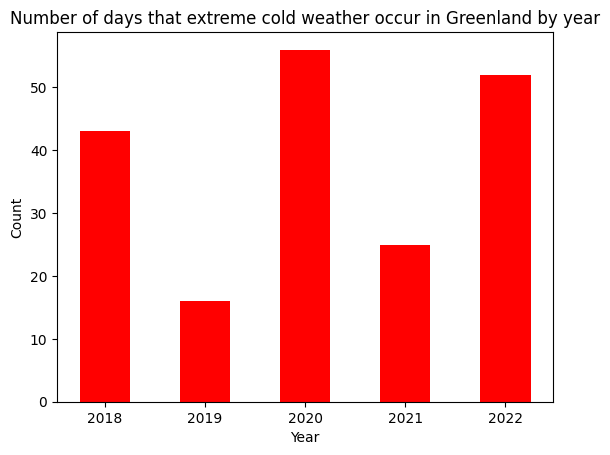

In [ ]:
plt.bar(extreme_cold_day_Greenland_by_year["year"], extreme_cold_day_Greenland_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in Greenland by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

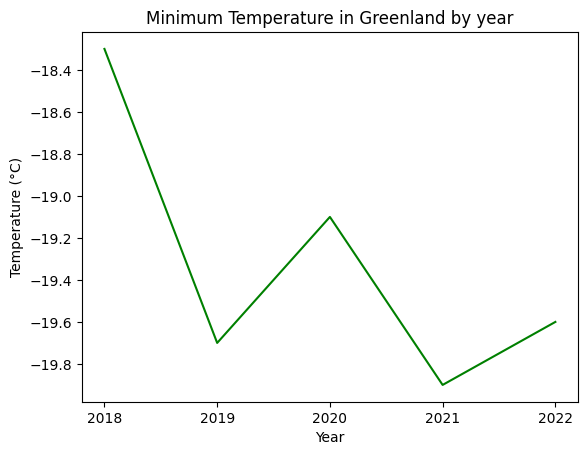

In [ ]:
min_temp_Greenland_by_year = df_Greenland_extreme_cold.groupby("year").min().toPandas()

plt.plot(min_temp_Greenland_by_year["year"], min_temp_Greenland_by_year["min(tmin)"], color = "green", linestyle = "-")

plt.title("Minimum Temperature in Greenland by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

In [ ]:
df_Russia = df[df["country"] == "Russia"]

mean_Russia_tavg = df_Russia.agg(mean("tavg")).collect()[0][0]
std_Russia_tavg = df_Russia.agg(stddev_pop("tavg")).collect()[0][0]

mean_Russia_tmin = df_Russia.agg(mean("tmin")).collect()[0][0]
std_Russia_tmin = df_Russia.agg(stddev_pop("tmin")).collect()[0][0]

mean_Russia_tmax = df_Russia.agg(mean("tmax")).collect()[0][0]
std_Russia_tmax = df_Russia.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Russia from 2018 to 2022 is:", mean_Russia_tavg, "°C")
print("The standard deviation of temperature in Russia from 2018 to 2022 is:", std_Russia_tavg, "°C")

print("The mean of min temperature in Russia from 2018 to 2022 is:", mean_Russia_tmin, "°C")
print("The standard deviation of min temperature in Russia from 2018 to 2022 is:", std_Russia_tmin, "°C")

print("The mean of max temperature in Russia from 2018 to 2022 is:", mean_Russia_tmax, "°C")
print("The standard deviation of max temperature in Russia from 2018 to 2022 is:", std_Russia_tmax, "°C")

df_Russia_extreme_cold = df_Russia[(df_Russia["tmin"] <= mean_Russia_tavg - 1.5*std_Russia_tavg)]



df_Russia_extreme_cold = df_Russia_extreme_cold.withColumn("year", year(F.to_date(df_Russia_extreme_cold["date"], "dd-MM-yyyy")))

extreme_cold_day_Russia_by_year = df_Russia_extreme_cold.groupby("year").count().toPandas()

extreme_cold_day_Russia_by_year

The mean of temperature in Russia from 2018 to 2022 is: 8.289682539682543 °C
The standard deviation of temperature in Russia from 2018 to 2022 is: 9.799186936978515 °C
The mean of min temperature in Russia from 2018 to 2022 is: 4.839947089947091 °C
The standard deviation of min temperature in Russia from 2018 to 2022 is: 9.01507655476124 °C
The mean of max temperature in Russia from 2018 to 2022 is: 11.747266313932975 °C
The standard deviation of max temperature in Russia from 2018 to 2022 is: 10.851989086344267 °C


,year,count
0,2019,5
1,2020,19
2,2021,63
3,2022,27


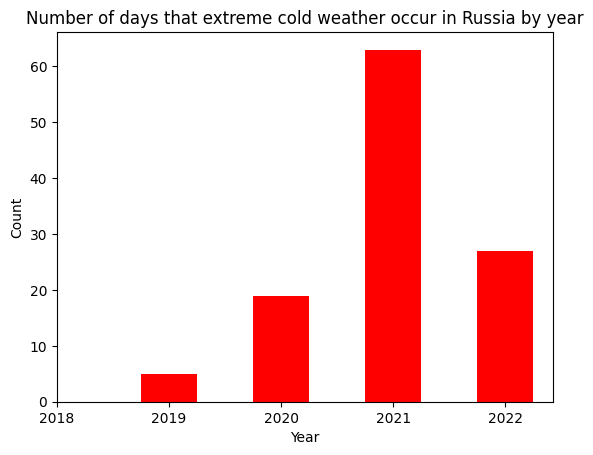

In [ ]:
plt.bar(extreme_cold_day_Russia_by_year["year"], extreme_cold_day_Russia_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in Russia by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

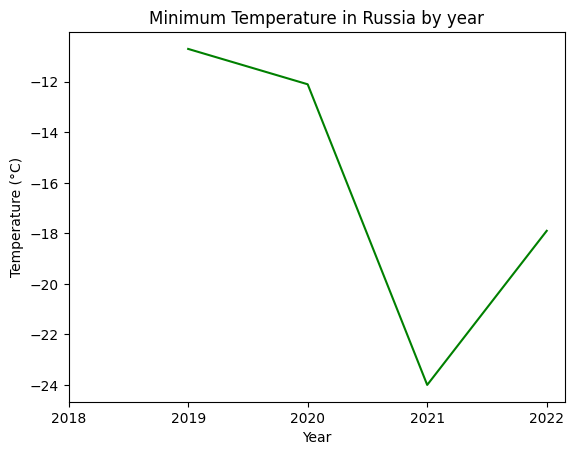

In [ ]:
min_temp_Russia_by_year = df_Russia_extreme_cold.groupby("year").min().toPandas()

plt.plot(min_temp_Russia_by_year["year"], min_temp_Russia_by_year["min(tmin)"], color = "green", linestyle = "-")

plt.title("Minimum Temperature in Russia by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

### Weather in Tropical Region Cities

In [ ]:
import pyspark.sql.functions as F


df_India = df[df["country"] == "India"]

mean_India_tavg = df_India.agg(mean("tavg")).collect()[0][0]
std_India_tavg = df_India.agg(stddev_pop("tavg")).collect()[0][0]

mean_India_tmin = df_India.agg(mean("tmin")).collect()[0][0]
std_India_tmin = df_India.agg(stddev_pop("tmin")).collect()[0][0]

mean_India_tmax = df_India.agg(mean("tmax")).collect()[0][0]
std_India_tmax = df_India.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in India from 2018 to 2022 is:", mean_India_tavg, "°C")
print("The standard deviation of temperature in India from 2018 to 2022 is:", std_India_tavg, "°C")

print("The mean of min temperature in India from 2018 to 2022 is:", mean_India_tmin, "°C")
print("The standard deviation of min temperature in India from 2018 to 2022 is:", std_India_tmin, "°C")

print("The mean of max temperature in India from 2018 to 2022 is:", mean_India_tmax, "°C")
print("The standard deviation of max temperature in India from 2018 to 2022 is:", std_India_tmax, "°C")

df_India_extreme_cold = df_India[(df_India["tmin"] <= mean_India_tmin - 1.5*std_India_tmin)]



df_India_extreme_cold = df_India_extreme_cold.withColumn("year", year(F.to_date(df_India_extreme_cold["date"], "dd-MM-yyyy")))

extreme_cold_day_India_by_year = df_India_extreme_cold.groupby("year").count().toPandas()

extreme_cold_day_India_by_year

The mean of temperature in India from 2018 to 2022 is: 26.89661144578313 °C
The standard deviation of temperature in India from 2018 to 2022 is: 7.290585133580807 °C
The mean of min temperature in India from 2018 to 2022 is: 20.888102409638556 °C
The standard deviation of min temperature in India from 2018 to 2022 is: 7.6218787813889435 °C
The mean of max temperature in India from 2018 to 2022 is: 33.43335843373495 °C
The standard deviation of max temperature in India from 2018 to 2022 is: 6.8144895802250005 °C


,year,count
0,2018,7
1,2019,23
2,2020,57
3,2021,41
4,2022,25


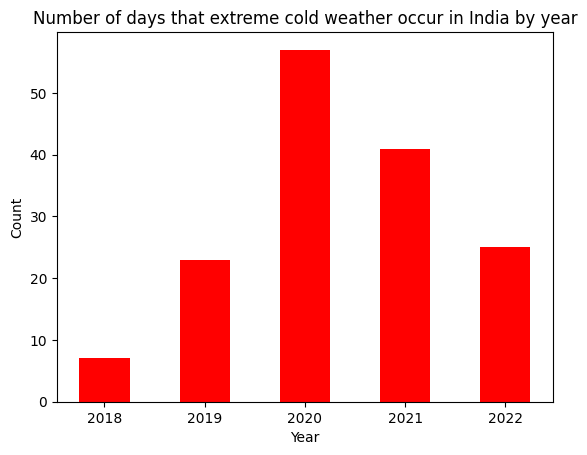

In [ ]:
plt.bar(extreme_cold_day_India_by_year["year"], extreme_cold_day_India_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in India by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

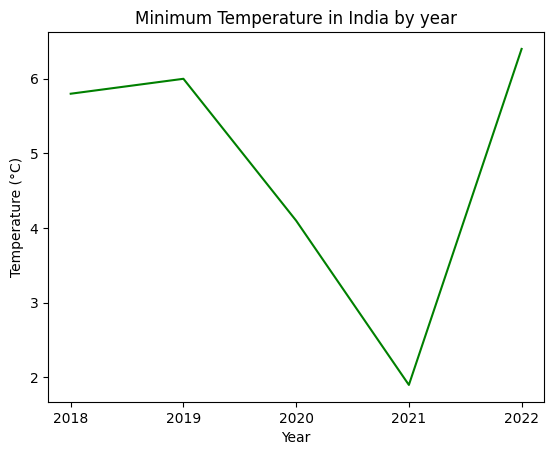

In [ ]:
min_temp_India_by_year = df_India_extreme_cold.groupby("year").min().toPandas()

plt.plot(min_temp_India_by_year["year"], min_temp_India_by_year["min(tmin)"], color = "green", linestyle = "-")

plt.title("Minimum Temperature in India by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

In [ ]:
import pyspark.sql.functions as F


df_Burkina_Faso = df[df["country"] == "Burkina Faso"]

mean_Burkina_Faso_tavg = df_Burkina_Faso.agg(mean("tavg")).collect()[0][0]
std_Burkina_Faso_tavg = df_Burkina_Faso.agg(stddev_pop("tavg")).collect()[0][0]

mean_Burkina_Faso_tmin = df_Burkina_Faso.agg(mean("tmin")).collect()[0][0]
std_Burkina_Faso_tmin = df_Burkina_Faso.agg(stddev_pop("tmin")).collect()[0][0]

mean_Burkina_Faso_tmax = df_Burkina_Faso.agg(mean("tmax")).collect()[0][0]
std_Burkina_Faso_tmax = df_Burkina_Faso.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tavg, "°C")
print("The standard deviation of temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tavg, "°C")

print("The mean of min temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tmin, "°C")
print("The standard deviation of min temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tmin, "°C")

print("The mean of max temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tmax, "°C")
print("The standard deviation of max temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tmax, "°C")

df_Burkina_Faso_extreme_cold = df_Burkina_Faso[(df_Burkina_Faso["tmin"] <= mean_Burkina_Faso_tmin - 1.5*std_Burkina_Faso_tmin)]



df_Burkina_Faso_extreme_cold = df_Burkina_Faso_extreme_cold.withColumn("year", year(F.to_date(df_Burkina_Faso_extreme_cold["date"], "dd-MM-yyyy")))

extreme_cold_day_Burkina_Faso_by_year = df_Burkina_Faso_extreme_cold.groupby("year").count().toPandas()

extreme_cold_day_Burkina_Faso_by_year

The mean of temperature in Burkina Faso from 2018 to 2022 is: 30.515576923076924 °C
The standard deviation of temperature in Burkina Faso from 2018 to 2022 is: 3.1021509784020482 °C
The mean of min temperature in Burkina Faso from 2018 to 2022 is: 24.671858974358965 °C
The standard deviation of min temperature in Burkina Faso from 2018 to 2022 is: 3.5990360718918115 °C
The mean of max temperature in Burkina Faso from 2018 to 2022 is: 37.00474358974358 °C
The standard deviation of max temperature in Burkina Faso from 2018 to 2022 is: 3.5030668703803443 °C


,year,count
0,2018,12
1,2019,36
2,2020,28
3,2021,29
4,2022,21


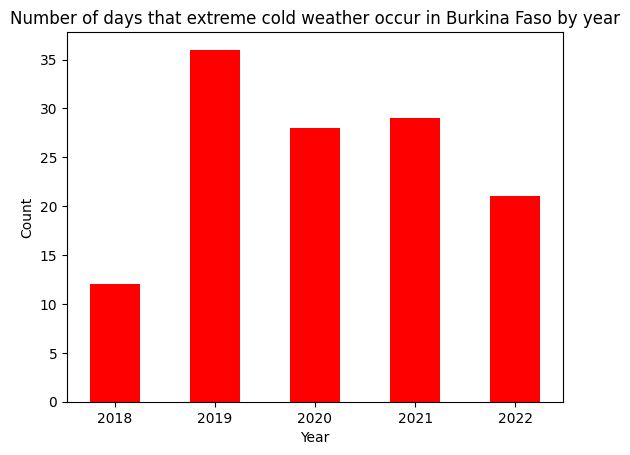

In [ ]:
plt.bar(extreme_cold_day_Burkina_Faso_by_year["year"], extreme_cold_day_Burkina_Faso_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in Burkina Faso by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

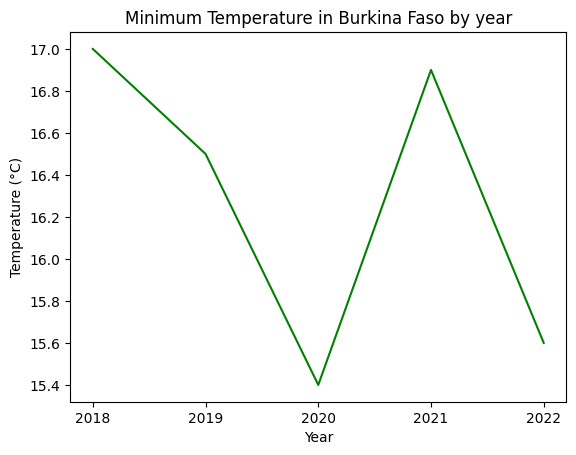

In [ ]:
min_temp_Burkina_Faso_by_year = df_Burkina_Faso_extreme_cold.groupby("year").min().toPandas()

plt.plot(min_temp_Burkina_Faso_by_year["year"], min_temp_Burkina_Faso_by_year["min(tmin)"], color = "green", linestyle = "-")

plt.title("Minimum Temperature in Burkina Faso by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

## Extreme Hot Weather

### Weather in Polar Region Cities

In [ ]:
df_Greenland = df[df["country"] == "Greenland"]

mean_Greenland_tavg = df_Greenland.agg(mean("tavg")).collect()[0][0]
std_Greenland_tavg = df_Greenland.agg(stddev_pop("tavg")).collect()[0][0]

mean_Greenland_tmin = df_Greenland.agg(mean("tmin")).collect()[0][0]
std_Greenland_tmin = df_Greenland.agg(stddev_pop("tmin")).collect()[0][0]

mean_Greenland_tmax = df_Greenland.agg(mean("tmax")).collect()[0][0]
std_Greenland_tmax = df_Greenland.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tavg, "°C")
print("The standard deviation of temperature in Greenland from 2018 to 2022 is:", std_Greenland_tavg, "°C")

print("The mean of min temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tmin, "°C")
print("The standard deviation of min temperature in Greenland from 2018 to 2022 is:", std_Greenland_tmin, "°C")

print("The mean of max temperature in Greenland from 2018 to 2022 is:", mean_Greenland_tmax, "°C")
print("The standard deviation of max temperature in Greenland from 2018 to 2022 is:", std_Greenland_tmax, "°C")

df_Greenland_extreme_hot = df_Greenland[(df_Greenland["tmax"] >= mean_Greenland_tavg + 1.5*std_Greenland_tavg)]



df_Greenland_extreme_hot = df_Greenland_extreme_hot.withColumn("year", year(F.to_date(df_Greenland_extreme_hot["date"], "dd-MM-yyyy")))

extreme_hot_day_Greenland_by_year = df_Greenland_extreme_hot.groupby("year").count().toPandas()

extreme_hot_day_Greenland_by_year

The mean of temperature in Greenland from 2018 to 2022 is: -0.015748963883955087 °C
The standard deviation of temperature in Greenland from 2018 to 2022 is: 6.888763517856457 °C
The mean of min temperature in Greenland from 2018 to 2022 is: -2.341207815275311 °C
The standard deviation of min temperature in Greenland from 2018 to 2022 is: 6.38584376212006 °C
The mean of max temperature in Greenland from 2018 to 2022 is: 2.842747187685021 °C
The standard deviation of max temperature in Greenland from 2018 to 2022 is: 7.604307372637845 °C


,year,count
0,2018,27
1,2019,69
2,2020,53
3,2021,68
4,2022,75


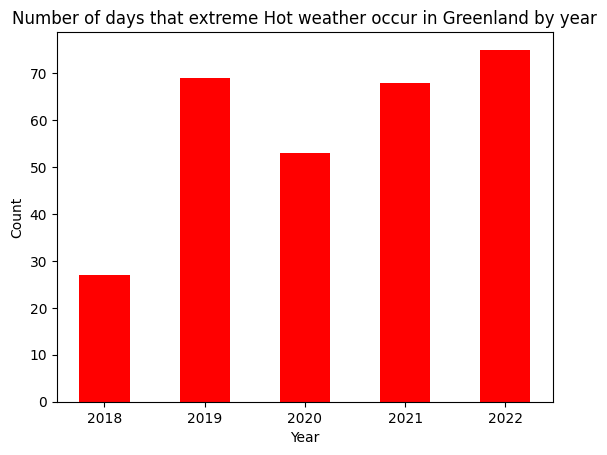

In [ ]:
plt.bar(extreme_hot_day_Greenland_by_year["year"], extreme_hot_day_Greenland_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme Hot weather occur in Greenland by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

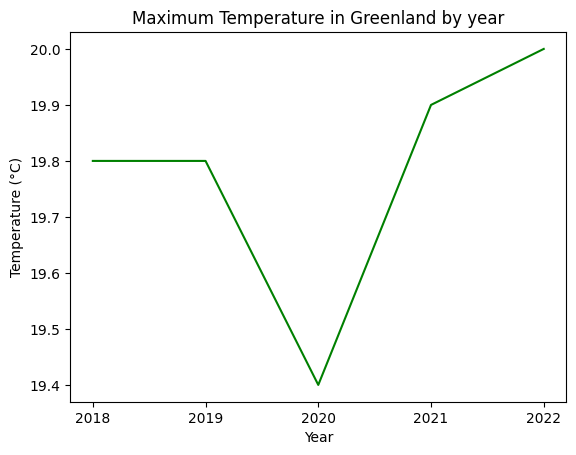

In [ ]:
max_temp_Greenland_by_year = df_Greenland_extreme_hot.groupby("year").max().toPandas()

plt.plot(max_temp_Greenland_by_year["year"], max_temp_Greenland_by_year["max(tmax)"], color = "green", linestyle = "-")

plt.title("Maximum Temperature in Greenland by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

In [ ]:
df_Russia = df[df["country"] == "Russia"]

mean_Russia_tavg = df_Russia.agg(mean("tavg")).collect()[0][0]
std_Russia_tavg = df_Russia.agg(stddev_pop("tavg")).collect()[0][0]

mean_Russia_tmin = df_Russia.agg(mean("tmin")).collect()[0][0]
std_Russia_tmin = df_Russia.agg(stddev_pop("tmin")).collect()[0][0]

mean_Russia_tmax = df_Russia.agg(mean("tmax")).collect()[0][0]
std_Russia_tmax = df_Russia.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Russia from 2018 to 2022 is:", mean_Russia_tavg, "°C")
print("The standard deviation of temperature in Russia from 2018 to 2022 is:", std_Russia_tavg, "°C")

print("The mean of min temperature in Russia from 2018 to 2022 is:", mean_Russia_tmin, "°C")
print("The standard deviation of min temperature in Russia from 2018 to 2022 is:", std_Russia_tmin, "°C")

print("The mean of max temperature in Russia from 2018 to 2022 is:", mean_Russia_tmax, "°C")
print("The standard deviation of max temperature in Russia from 2018 to 2022 is:", std_Russia_tmax, "°C")

df_Russia_extreme_hot = df_Russia[(df_Russia["tmax"] >= mean_Russia_tavg + 1.5*std_Russia_tavg)]



df_Russia_extreme_hot = df_Russia_extreme_hot.withColumn("year", year(F.to_date(df_Russia_extreme_hot["date"], "dd-MM-yyyy")))

extreme_hot_day_Russia_by_year = df_Russia_extreme_hot.groupby("year").count().toPandas()

extreme_hot_day_Russia_by_year

The mean of temperature in Russia from 2018 to 2022 is: 8.289682539682543 °C
The standard deviation of temperature in Russia from 2018 to 2022 is: 9.799186936978515 °C
The mean of min temperature in Russia from 2018 to 2022 is: 4.839947089947091 °C
The standard deviation of min temperature in Russia from 2018 to 2022 is: 9.01507655476124 °C
The mean of max temperature in Russia from 2018 to 2022 is: 11.747266313932975 °C
The standard deviation of max temperature in Russia from 2018 to 2022 is: 10.851989086344267 °C


,year,count
0,2019,24
1,2020,37
2,2021,78
3,2022,68


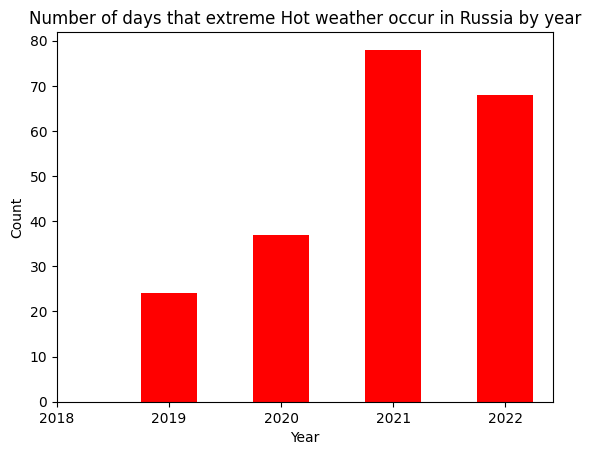

In [ ]:
plt.bar(extreme_hot_day_Russia_by_year["year"], extreme_hot_day_Russia_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme Hot weather occur in Russia by year")
plt.xlabel("Year")
plt.xticks(range(2018, 2023))
plt.ylabel("Count")

plt.show()

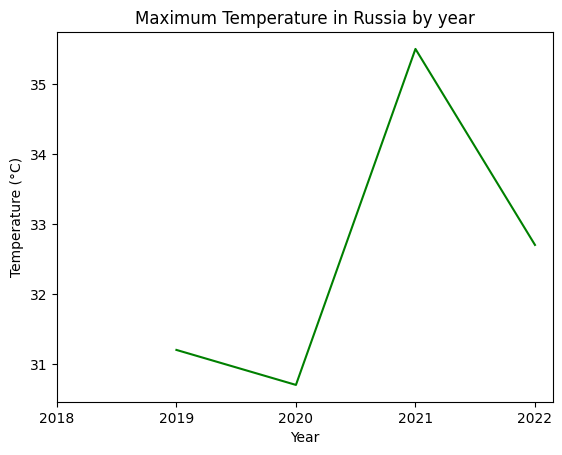

In [ ]:
max_temp_Russia_by_year = df_Russia_extreme_hot.groupby("year").max().toPandas()

plt.plot(max_temp_Russia_by_year["year"], max_temp_Russia_by_year["max(tmax)"], color = "green", linestyle = "-")

plt.title("Maximum Temperature in Russia by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

### Weather in Tropical Region Cities

In [ ]:
import pyspark.sql.functions as F


df_India = df[df["country"] == "India"]

mean_India_tavg = df_India.agg(mean("tavg")).collect()[0][0]
std_India_tavg = df_India.agg(stddev_pop("tavg")).collect()[0][0]

mean_India_tmin = df_India.agg(mean("tmin")).collect()[0][0]
std_India_tmin = df_India.agg(stddev_pop("tmin")).collect()[0][0]

mean_India_tmax = df_India.agg(mean("tmax")).collect()[0][0]
std_India_tmax = df_India.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in India from 2018 to 2022 is:", mean_India_tavg, "°C")
print("The standard deviation of temperature in India from 2018 to 2022 is:", std_India_tavg, "°C")

print("The mean of min temperature in India from 2018 to 2022 is:", mean_India_tmin, "°C")
print("The standard deviation of min temperature in India from 2018 to 2022 is:", std_India_tmin, "°C")

print("The mean of max temperature in India from 2018 to 2022 is:", mean_India_tmax, "°C")
print("The standard deviation of max temperature in India from 2018 to 2022 is:", std_India_tmax, "°C")

df_India_extreme_hot = df_India[(df_India["tmax"] >= mean_India_tmax + 1.5*std_India_tmax)]



df_India_extreme_hot = df_India_extreme_hot.withColumn("year", year(F.to_date(df_India_extreme_hot["date"], "dd-MM-yyyy")))

extreme_hot_day_India_by_year = df_India_extreme_hot.groupby("year").count().toPandas()

extreme_hot_day_India_by_year

The mean of temperature in India from 2018 to 2022 is: 26.89661144578313 °C
The standard deviation of temperature in India from 2018 to 2022 is: 7.290585133580807 °C
The mean of min temperature in India from 2018 to 2022 is: 20.888102409638556 °C
The standard deviation of min temperature in India from 2018 to 2022 is: 7.6218787813889435 °C
The mean of max temperature in India from 2018 to 2022 is: 33.43335843373495 °C
The standard deviation of max temperature in India from 2018 to 2022 is: 6.8144895802250005 °C


,year,count
0,2018,1
1,2019,15
2,2020,7
3,2021,2
4,2022,18


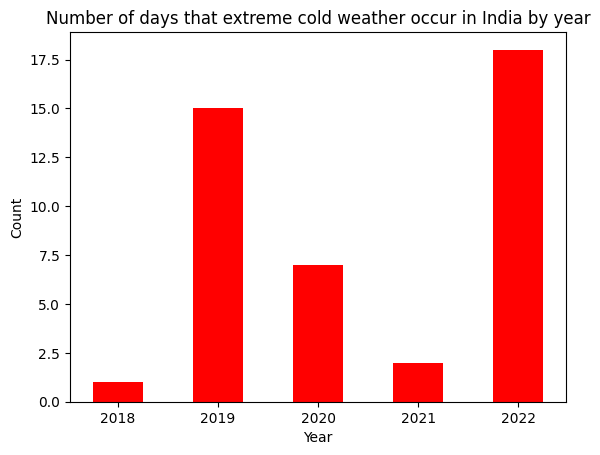

In [ ]:
plt.bar(extreme_hot_day_India_by_year["year"], extreme_hot_day_India_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in India by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

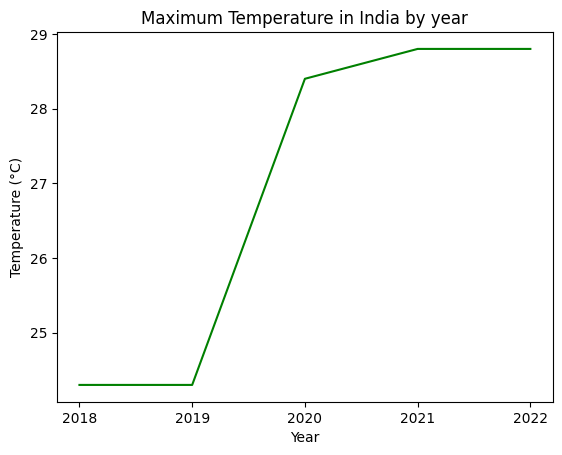

In [ ]:
max_temp_India_by_year = df_India_extreme_cold.groupby("year").max().toPandas()

plt.plot(max_temp_India_by_year["year"], max_temp_India_by_year["max(tmax)"], color = "green", linestyle = "-")

plt.title("Maximum Temperature in India by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()

In [ ]:
import pyspark.sql.functions as F


df_Burkina_Faso = df[df["country"] == "Burkina Faso"]

mean_Burkina_Faso_tavg = df_Burkina_Faso.agg(mean("tavg")).collect()[0][0]
std_Burkina_Faso_tavg = df_Burkina_Faso.agg(stddev_pop("tavg")).collect()[0][0]

mean_Burkina_Faso_tmin = df_Burkina_Faso.agg(mean("tmin")).collect()[0][0]
std_Burkina_Faso_tmin = df_Burkina_Faso.agg(stddev_pop("tmin")).collect()[0][0]

mean_Burkina_Faso_tmax = df_Burkina_Faso.agg(mean("tmax")).collect()[0][0]
std_Burkina_Faso_tmax = df_Burkina_Faso.agg(stddev_pop("tmax")).collect()[0][0]

print("The mean of temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tavg, "°C")
print("The standard deviation of temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tavg, "°C")

print("The mean of min temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tmin, "°C")
print("The standard deviation of min temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tmin, "°C")

print("The mean of max temperature in Burkina Faso from 2018 to 2022 is:", mean_Burkina_Faso_tmax, "°C")
print("The standard deviation of max temperature in Burkina Faso from 2018 to 2022 is:", std_Burkina_Faso_tmax, "°C")

df_Burkina_Faso_extreme_hot = df_Burkina_Faso[(df_Burkina_Faso["tmax"] >= mean_Burkina_Faso_tmax + 1.5*std_Burkina_Faso_tmax)]



df_Burkina_Faso_extreme_hot = df_Burkina_Faso_extreme_hot.withColumn("year", year(F.to_date(df_Burkina_Faso_extreme_hot["date"], "dd-MM-yyyy")))

extreme_hot_day_Burkina_Faso_by_year = df_Burkina_Faso_extreme_hot.groupby("year").count().toPandas()

extreme_hot_day_Burkina_Faso_by_year

The mean of temperature in Burkina Faso from 2018 to 2022 is: 30.515576923076924 °C
The standard deviation of temperature in Burkina Faso from 2018 to 2022 is: 3.1021509784020482 °C
The mean of min temperature in Burkina Faso from 2018 to 2022 is: 24.671858974358965 °C
The standard deviation of min temperature in Burkina Faso from 2018 to 2022 is: 3.5990360718918115 °C
The mean of max temperature in Burkina Faso from 2018 to 2022 is: 37.00474358974358 °C
The standard deviation of max temperature in Burkina Faso from 2018 to 2022 is: 3.5030668703803443 °C


,year,count
0,2019,24
1,2020,43
2,2021,39
3,2022,27


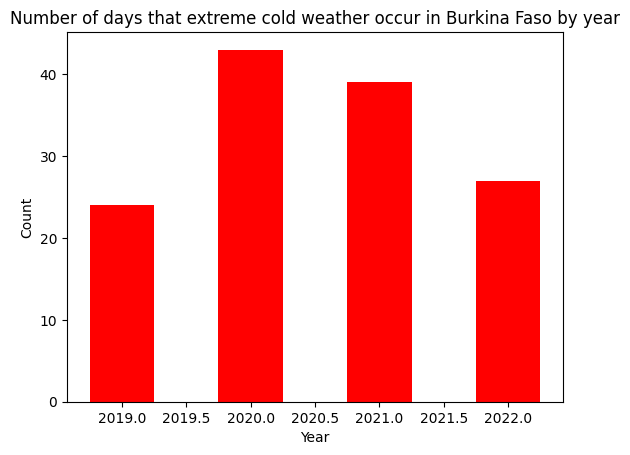

In [ ]:
plt.bar(extreme_hot_day_Burkina_Faso_by_year["year"], extreme_hot_day_Burkina_Faso_by_year["count"], color = "red", width = 0.5)

plt.title("Number of days that extreme cold weather occur in Burkina Faso by year")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

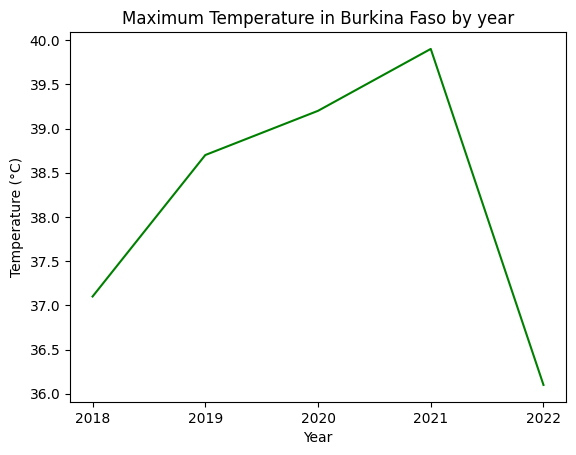

In [ ]:
max_temp_Burkina_Faso_by_year = df_Burkina_Faso_extreme_cold.groupby("year").max().toPandas()

plt.plot(max_temp_Burkina_Faso_by_year["year"], max_temp_Burkina_Faso_by_year["max(tmax)"], color = "green", linestyle = "-")

plt.title("Maximum Temperature in Burkina Faso by year")
plt.xticks(range(2018, 2023))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")

plt.show()